# Nx versus T and OA

In [1]:
%load_ext autoreload

%autoreload 2

In [2]:
import matplotlib.pyplot as plt
from pathlib import Path

In [3]:
from IPython import get_ipython

# noinspection PyBroadException
try:
    _ipython = get_ipython()
    _magic = _ipython.magic
    _magic('load_ext autoreload')
    _magic('autoreload 2')
except:
    pass

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
import scienceplots
import scienceplots
plt.style.use([
    'default',
    # 'science',
    'acp',
    # 'sp-grid',
    'no-black',
    'no-latex',
    'illustrator-safe'
])

In [5]:

import numpy as np

label_dic =dict(
    T_C=r'T  [$^\circ$C]',
    OA =r'OA [$\mu g m^{-3}$]',
)

In [6]:
select_station = 'SMR'

In [7]:
plot_path = Path(f'Plots/{select_station}')

In [8]:
def make_fn_scat(case, v_x, v_y):
    _x = v_x.split('(')[0]
    _y = v_y.split('(')[0]
    f = f'scat_all_years_echam_noresm_{case}_{_x}_{_y}-{select_station}_ukesm.png'
    return plot_path /f

In [9]:
plot_path.mkdir(exist_ok=True, parents=True)

In [10]:
from bs_fdbck_clean.constants import path_measurement_data
postproc_data = path_measurement_data /'model_station'/select_station
postproc_data_obs = path_measurement_data /'SMEARII'/'processed'

/proj/bolinc/users/x_sarbl/analysis/BS-FDBCK_clean/bs_fdbck_clean/data_info


In [11]:
fn_obs_comb_data_full_time =postproc_data_obs /'SMEAR_data_comb_hourly.csv'

In [12]:
fn_obs_comb_data_full_time

PosixPath('/proj/bolinc/users/x_sarbl/analysis/BS-FDBCK_clean/Data/SMEARII/processed/SMEAR_data_comb_hourly.csv')

In [13]:
plot_path = Path(f'Plots/{select_station}')

In [14]:
def make_fn_eval(case,_type):
    #_x = v_x.split('(')[0]
    #_y = v_y.split('(')[0]
    f = f'evalOA_echam_{case}_{_type}_{select_station}.png'
    return plot_path /f

## Read in model data. 

In [15]:
models = ['ECHAM-SALSA','NorESM', 'EC-Earth', 'UKESM']
mod2cases = {'ECHAM-SALSA' : ['SALSA_BSOA_feedback'],
             'NorESM' : ['OsloAero_intBVOC_f09_f09_mg17_fssp'],
             'EC-Earth' : ['ECE3_output_Sara'],
             'UKESM' : ['AEROCOMTRAJ'],
             'Observations':['Obs'],
            }
di_mod2cases = mod2cases.copy()

In [16]:
from bs_fdbck_clean.preprocess.launch_monthly_station_collocation import launch_monthly_station_output
from bs_fdbck_clean.util.Nd.sizedist_class_v2.SizedistributionBins import SizedistributionStationBins
from bs_fdbck_clean.util.collocate.collocateLONLAToutput import CollocateLONLATout
from bs_fdbck_clean.data_info.variable_info import list_sized_vars_nonsec, list_sized_vars_noresm
import useful_scit.util.log as log
log.ger.setLevel(log.log.INFO)
import time

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

In [18]:
import numpy as np

In [19]:
import numpy as np
from sklearn.linear_model import LinearRegression, BayesianRidge

### Constants:

In [20]:
R = 287.058
pressure = 1000. #hPa
kg2ug = 1e9
temperature = 273.15

In [21]:
import pandas as pd

## Read in model data

In [22]:
dic_df_pre=dict()
for mod in models:
    print(mod)
    dic_df_pre[mod] = dict()
    for ca in mod2cases[mod]:
        print(mod, ca)
        fn_out = postproc_data/f'{select_station}_station_{mod}_{ca}.csv'
        print(fn_out)
        dic_df_pre[mod][ca] = pd.read_csv(fn_out, index_col=0)
        dic_df_pre[mod][ca].index = pd.to_datetime(dic_df_pre[mod][ca].index)
        #dic_df_mod_case[mod][ca].to_csv(fn_out)

ECHAM-SALSA
ECHAM-SALSA SALSA_BSOA_feedback
/proj/bolinc/users/x_sarbl/analysis/BS-FDBCK_clean/Data/model_station/SMR/SMR_station_ECHAM-SALSA_SALSA_BSOA_feedback.csv
NorESM
NorESM OsloAero_intBVOC_f09_f09_mg17_fssp
/proj/bolinc/users/x_sarbl/analysis/BS-FDBCK_clean/Data/model_station/SMR/SMR_station_NorESM_OsloAero_intBVOC_f09_f09_mg17_fssp.csv
EC-Earth
EC-Earth ECE3_output_Sara
/proj/bolinc/users/x_sarbl/analysis/BS-FDBCK_clean/Data/model_station/SMR/SMR_station_EC-Earth_ECE3_output_Sara.csv
UKESM
UKESM AEROCOMTRAJ
/proj/bolinc/users/x_sarbl/analysis/BS-FDBCK_clean/Data/model_station/SMR/SMR_station_UKESM_AEROCOMTRAJ.csv


## Read in observations

In [23]:
df_obs = pd.read_csv(fn_obs_comb_data_full_time,index_col=0)

In [24]:
df_obs = df_obs.rename({'Org_STP':'OA', 'HYY_META.T168':'T_C'}, axis=1)

In [25]:
df_obs

Year  Month  Day  Hour  Minute  Second  \
time                                                            
2012-01-01 00:00:00  2012.0    1.0  1.0   0.0    29.5     0.0   
2012-01-01 01:00:00  2012.0    1.0  1.0   1.0    29.5     0.0   
2012-01-01 02:00:00  2012.0    1.0  1.0   2.0    29.5     0.0   
2012-01-01 03:00:00  2012.0    1.0  1.0   3.0    29.5     0.0   
2012-01-01 04:00:00  2012.0    1.0  1.0   4.0    29.5     0.0   
...                     ...    ...  ...   ...     ...     ...   
2020-12-31 19:00:00     NaN    NaN  NaN   NaN     NaN     NaN   
2020-12-31 20:00:00     NaN    NaN  NaN   NaN     NaN     NaN   
2020-12-31 21:00:00     NaN    NaN  NaN   NaN     NaN     NaN   
2020-12-31 22:00:00     NaN    NaN  NaN   NaN     NaN     NaN   
2020-12-31 23:00:00     NaN    NaN  NaN   NaN     NaN     NaN   

                     HYY_META.WDU672  HYY_META.WSU168  HYY_META.WSU672  \
time                                                                     
2012-01-01 00:00:00              NaN         0.768877              NaN   
2012-01-01 01:00:00              NaN         0.487818              NaN   
2012-01-01 02:00:00              NaN         0.553307              NaN   
2012-01-01 03:00:00              NaN         0.523611              NaN   
2012-01-01 04:00:00              NaN         0.540031              NaN   
...                              ...              ...              ...   
2020-12-31 19:00:00              NaN              NaN              NaN   
2020-12-31 20:00:00              NaN              NaN              NaN   
2020-12-31 21:00:00              NaN              NaN              NaN   
2020-12-31 22:00:00              NaN              NaN              NaN   
2020-12-31 23:00:00              NaN              NaN              NaN   

                     HYY_META.T672  ...        N150        N200       N250  \
time                                ...                                      
2012-01-01 00:00:00      -6.228155  ...         NaN         NaN        NaN   
2012-01-01 01:00:00      -5.951797  ...         NaN         NaN        NaN   
2012-01-01 02:00:00      -5.993273  ...  137.173123   87.040280  52.205053   
2012-01-01 03:00:00      -5.995248  ...  152.428974   96.878629  59.321288   
2012-01-01 04:00:00      -5.883390  ...  189.614898  117.824268  70.343558   
...                            ...  ...         ...         ...        ...   
2020-12-31 19:00:00            NaN  ...         NaN         NaN        NaN   
2020-12-31 20:00:00            NaN  ...         NaN         NaN        NaN   
2020-12-31 21:00:00            NaN  ...         NaN         NaN        NaN   
2020-12-31 22:00:00            NaN  ...         NaN         NaN        NaN   
2020-12-31 23:00:00            NaN  ...         NaN         NaN        NaN   

                          N300  density  OA  SO4_STP  NO3_STP  NH4_STP  \
time                                                                     
2012-01-01 00:00:00        NaN      NaN NaN      NaN      NaN      NaN   
2012-01-01 01:00:00        NaN      NaN NaN      NaN      NaN      NaN   
2012-01-01 02:00:00  29.899803      NaN NaN      NaN      NaN      NaN   
2012-01-01 03:00:00  33.998613      NaN NaN      NaN      NaN      NaN   
2012-01-01 04:00:00  39.921649      NaN NaN      NaN      NaN      NaN   
...                        ...      ...  ..      ...      ...      ...   
2020-12-31 19:00:00        NaN      NaN NaN      NaN      NaN      NaN   
2020-12-31 20:00:00        NaN      NaN NaN      NaN      NaN      NaN   
2020-12-31 21:00:00        NaN      NaN NaN      NaN      NaN      NaN   
2020-12-31 22:00:00        NaN      NaN NaN      NaN      NaN      NaN   
2020-12-31 23:00:00        NaN      NaN NaN      NaN      NaN      NaN   

                     Chl_STP  
time                          
2012-01-01 00:00:00      NaN  
2012-01-01 01:00:00      NaN  
2012-01-01 02:00:00      NaN  
2012-01-01 03:00:00      NaN  
2012-01-01 04:00:00      NaN  
...                

In [26]:
dic_df_pre['Observations']=dict()
dic_df_pre['Observations']['Observations'] = df_obs
dic_df_pre['Observations']['Observations'].index = pd.to_datetime(dic_df_pre['Observations']['Observations'].index)

In [27]:
mod2cases['Observations']= ['Observations']

In [28]:
dic_mod_ca = dic_df_pre.copy()

### Fit funcs

In [29]:
from bs_fdbck_clean.util.BSOA_datamanip.fits import *
from bs_fdbck_clean.util.BSOA_datamanip.atto import season2month

### season to monthseason2month

In [30]:
def select_months(df, season = None, month_list=None):
    if season is not None: 
        month_list = season2month[season]
    

    df['month'] = df.index.month
    return df['month'].isin(month_list)

### Some definitions:

In [31]:
models = ['ECHAM-SALSA','NorESM', 'EC-Earth', 'UKESM']
mod2cases = {'ECHAM-SALSA' : ['SALSA_BSOA_feedback'],
             'NorESM' : ['OsloAero_intBVOC_f09_f09_mg17_fssp'],
             'EC-Earth' : ['ECE3_output_Sara'],
             'UKESM' : ['AEROCOMTRAJ'],
             'Observations':['Obs'],
            }
di_mod2cases = mod2cases.copy()

### Save result in dictionary

In [32]:
dic_df_mod_case = dic_mod_ca.copy()

In [33]:
from bs_fdbck_clean.util.BSOA_datamanip import calculate_daily_median_summer,calculate_summer_median

# Merge with observations:

In [34]:
dic_df_pre = dict()#dic_df_mod_case.copy()#deep=True)
for mod in dic_df_mod_case.keys():
    dic_df_pre[mod] = dic_df_mod_case[mod].copy()

## Rename STP values

In [35]:
for mod in models:
    for ca in mod2cases[mod]:
        _df = dic_df_pre[mod][ca]
        for v in ['OA','N50','N100','N200']:
            if f'{v}_STP' in _df.columns:
                if v in _df.columns:
                    _df = _df.rename({v:f'{v}_orig'}, axis=1)
                _df = _df.rename({f'{v}_STP':v}, axis=1)
        dic_df_pre[mod][ca] = _df

In [36]:
vars_obs = ['OA', 'N100','N50','N200','T_C']

In [37]:
df_obs = df_obs[vars_obs]

In [38]:
df_obs['some_obs_missing'] = df_obs[vars_obs].isnull().any(axis=1)

/tmp/ipykernel_73628/3053598488.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_obs['some_obs_missing'] = df_obs[vars_obs].isnull().any(axis=1)


In [39]:
df_for_merge = df_obs[['OA','N100', 'some_obs_missing']].rename({'OA':'obs_OA','N100':'obs_N100',},axis=1)

In [40]:
for mod in dic_df_mod_case.keys():
    print(mod)
    for ca in dic_df_mod_case[mod].keys():
        dic_df_mod_case[mod][ca] = pd.merge(dic_df_pre[mod][ca], df_for_merge ,right_on='time', left_on='time', how='outer')
        dic_df_mod_case[mod][ca]['year'] = dic_df_mod_case[mod][ca].index.year

ECHAM-SALSA
NorESM
EC-Earth
UKESM
Observations


## Add observations to dictionary

In [41]:
dic_df_mod_case['Observations'] = dict()
dic_df_mod_case['Observations']['Observations'] = df_obs

In [42]:
dic_df_mod_case['Observations'].keys()

dict_keys(['Observations'])

In [43]:
dic_mod2case = mod2cases

In [44]:
def add_log(df, varl=None):
    if varl is None:
        varl = ['OA','N100', 'Org','N100 (cm^-3)','N50','N150','N200']
    var_exist = df.columns
    
    varl_f = set(varl).intersection(var_exist)
    print(varl_f)
    for v in varl_f:
        df[f'log10({v})'] = np.log10(df[v])
    return df


for mod in dic_df_mod_case.keys():
    for c in dic_df_mod_case[mod].keys():
    
        dic_df_mod_case[mod][c] = add_log(dic_df_mod_case[mod][c].copy())
        #dic_dfsm_mod_case[mod][c] = add_log(dic_dfsm_mod_case[mod][c])
        
dic_df_mod_case['Observations']['Observations'] = add_log(dic_df_mod_case['Observations']['Observations'])
df_ons = dic_df_mod_case['Observations']['Observations']

{'N100', 'N200', 'N50', 'OA'}
{'OA', 'N150', 'N100', 'N200', 'N50'}
{'OA', 'N150', 'N100', 'N200', 'N50'}
{'OA', 'N150', 'N100', 'N200', 'N50'}
{'N100', 'N200', 'N50', 'OA'}
{'N100', 'N200', 'N50', 'OA'}


/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [45]:
mod='NorESM'

In [46]:
ca = mod2cases[mod][0]

## Compute daily medians:

### Save daily medians 

In [47]:
path_save_daily_medians = Path(f'Temp_data/{select_station}_daily_medians')
path_save_daily_medians.parent.mkdir(exist_ok=True)

In [48]:
min_obs = 5

In [49]:
dic_df_med = dict()
for mo in dic_df_mod_case.keys():
    for ca in dic_df_mod_case[mo].keys():
        if len(dic_df_mod_case[mo].keys())>1:
            use_name = f'{mo}_{ca}'
        else:
            use_name = mo
            
        _df = dic_df_mod_case[mo][ca]
        
        #_df = _df[_df['some_obs_missing']==False]
        _df_med = _df.resample('D').median()
        _df_count =_df.resample('D').count()
        
        _df_med = _df_med[_df_count['OA']>min_obs]
        dic_df_med[use_name] = _df_med
        
        fp = path_save_daily_medians.parent / f'{path_save_daily_medians.name}_{use_name}.csv'
        #dic_df_med[use_name].to_csv(fp)

In [50]:
min_obs = 5

In [51]:
from bs_fdbck_clean.util.plot.BSOA_plots import cdic_model
import seaborn as sns
from matplotlib import pyplot as plt, gridspec as gridspec
from bs_fdbck_clean.util.plot.BSOA_plots import make_cool_grid2, make_cool_grid3
import scipy

### Fit funcs

In [52]:
from bs_fdbck_clean.util.BSOA_datamanip.fits import *
from bs_fdbck_clean.util.BSOA_datamanip.atto import season2month

### season to monthseason2month

In [53]:
def select_months(df, season = None, month_list=None):
    if season is not None: 
        month_list = season2month[season]
    

    df['month'] = df.index.month
    return df['month'].isin(month_list)

In [54]:
from bs_fdbck_clean.util.BSOA_datamanip.fits import *

In [55]:
from bs_fdbck_clean.util.plot.BSOA_plots import cdic_model, make_cool_grid5

In [56]:
models

['ECHAM-SALSA', 'NorESM', 'EC-Earth', 'UKESM']

In [57]:
models_and_obs =  models + ['Observations'] 
models_and_obs

['ECHAM-SALSA', 'NorESM', 'EC-Earth', 'UKESM', 'Observations']

## Make plot

In [58]:
def make_plot(v_x, v_y, xlims, ylims, season, 
              xlab=None, ylab=None, alpha_scat=.2,
             source_list = models_and_obs, fig=None, ax=None, daxs=None, axs_extra=None,
              xscale='linear', yscale='linear',
              dic_df_med = dic_df_med,
             ):
    if fig is None: 
        fig, ax, daxs, axs_extra = make_cool_grid3(ncols_extra=2, nrows_extra=3,)# w_ratio_sideplot=.5)

    if xlab is None: 
        if xlab in label_dic:
            xlab = label_dic[v_x]
    if ylab is None: 
        if ylab in label_dic:
            ylab = label_dic[v_y]

    for mo, ax_ex in zip(source_list, axs_extra[:]):
        print(mo)
        df_s =  dic_df_med[mo]

        mask_months = select_months(df_s, season=season)
        df_s = df_s[mask_months].copy()


        sns.scatterplot(x=v_x,y=v_y, 
                    data = df_s, 
                    color=cdic_model[mo], 
                    alpha=alpha_scatt*.7, 
                    label='__nolegend__',
                    ax = ax,
                    #facecolor='none',
                    edgecolor=cdic_model[mo],
                        marker='.',
                    
                   )
        sns.scatterplot(x=v_x,y=v_y, 
                    data = df_s, 
                    color=cdic_model[mo], 
                    alpha=alpha_scatt+.1, 
                    label='__nolegend__',
                    ax = ax_ex,
                    #facecolor='none',
                    edgecolor=cdic_model[mo],
                        marker='.',
                    
                    
                   )
        ax_ex.set_title(mo, y=.95)
        
    ax.set_xlabel(xlab)
    ax.set_ylabel(ylab)
    fig.suptitle(f'{select_station}, {season} season, 2012-2018', y=.95)
    xlim_dist = list(daxs['y'].get_xlim())
    for mo in source_list:
        print(mo)

        df_s =  dic_df_med[mo]

        mask_months = select_months(df_s, season=season)
        df_s = df_s[mask_months].copy()
        if xscale=='log':
            xbins = np.logspace(np.log10(xlims[0]),np.log10(xlims[1]),20)
        else:
            xbins = np.linspace(xlims[0],xlims[1],20)
            
        if yscale=='log':
            ybins = np.logspace(np.log10(ylims[0]),np.log10(ylims[1]),20)
        else:
            ybins = np.linspace(ylims[0],ylims[1],20)
            

        sns.histplot(#x=v_x,
                    x= df_s[v_x], 
            edgecolor=cdic_model[mo],
            #log_scale=(xscale=='log'),
            color=cdic_model[mo], 
            element="step",
            label=mo,
            linewidth=1,
            #log_scale=(xscale=='log',False,),

            alpha=.1,
            bins=xbins,
            ax = daxs['x'],
                    
                   )
        print(daxs['x'].get_ylim())
        _fi, ax_test = plt.subplots();
        ax_test = sns.histplot(#x=v_x,
            y=df_s[v_y],
            color=cdic_model[mo], 
            element="step",
            label=mo,
            ax = ax_test,
            #ax = daxs['y'],
            linewidth=2,
            
            #edgecolor=None,
            #log_scale=(False,yscale=='log'),
            alpha=.1,
            bins=ybins,
        );
        
        sns.histplot(#x=v_x,
            y=df_s[v_y],
            color=cdic_model[mo], 
            element="step",
            label=mo,
            ax = daxs['y'],
            linewidth=1,
            
            #edgecolor=None,
            #log_scale=(xscale=='log',yscale=='log'),
            #log_scale=(False,yscale=='log'),
            
            alpha=.1,
            bins=ybins,
            )
        xlim_dist_n = list(ax_test.get_xlim())
        _fi.clf()
        #if xlim_dist_n[1]>xlim_dist_n[1]:
        xlim_dist[1] = max(xlim_dist_n[1],xlim_dist[1])
        #daxs['y'].set_xlim([0,xlim_dist[1]])
        
        #plt.show()

    ax.set_ylim(ylims)
    ax.set_xlim(xlims)


    for ax_e in axs_extra:
        ax_e.set_xlabel('')
        ax_e.set_ylabel('')
        ax_e.set_ylim(ax.get_ylim())
        ax_e.set_xlim(ax.get_xlim())
        ax_e.axes.xaxis.set_ticklabels([])
        ax_e.axes.yaxis.set_ticklabels([])

        sns.despine(ax = ax_e)

    return

#### WET_mid

# Emissions

In [59]:
dict_emissions= {
    'emiisop':'emiisop',
    'emiterp':'emiterp',
    'SFisoprene':'emiisop',
    'SFmonoterp':'emiterp',
    'emi_isop_bio':'emiisop',
    'emi_monot_bio':'emiterp',
    'SFisoprene':'emiisop',
    'SFterpene':'emiterp',
}

### UKESM has units: kgC m-2 s-1

for isoprene that should be a correction of M_isop = 68.11702 versus M_isop_c_only = 60.05

In [60]:
M_isop = 68.11702
M_isop_c_only = 12.01*5
ukesm_isop_unit_correction = M_isop/M_isop_c_only
print('correction isop',ukesm_isop_unit_correction)

M_terp = 136.24
M_terp_c_only = 12.01*10
ukesm_terp_unit_correction = M_terp/M_terp_c_only
print('correction terp',ukesm_terp_unit_correction)

correction isop 1.1343383846794337
correction terp 1.1343880099916737


### NorESM has units: kg m-2 s-1

### EC-Earth has units kg m-2 s-1

### ECHAM-SALSA has units kg m-2 s-1

In [61]:
for m in models:
    print(m)
    _df = dic_df_med[m]
    if m=='UKESM':
        if 'SFisoprene' in _df.columns:
            _df['SFisoprene'] = _df['SFisoprene']*ukesm_isop_unit_correction
            print('corrected UKESM isop emi by factor',ukesm_isop_unit_correction)
        if 'SFterpene' in _df.columns:
            _df['SFterpene'] = _df['SFterpene']*ukesm_terp_unit_correction
            print('corrected UKESM terp emi by factor',ukesm_terp_unit_correction)
        
    _df = _df.rename(dict_emissions, axis=1)
    
    dic_df_med[m] = _df


ECHAM-SALSA
NorESM
EC-Earth
UKESM
corrected UKESM isop emi by factor 1.1343383846794337
corrected UKESM terp emi by factor 1.1343880099916737


### Change units to $\mu g$

In [62]:
vars_emi = ['emiisop','emiterp']


In [63]:
for m in models:
    _df = dic_df_med[m]
    for v in vars_emi:
        print(_df[v].mean())
        if _df[v].mean()<1e-9:
            _df[v] = _df[v]*1e9
            print('changes units for {v} from kg/m2/s to ug/m2/s')
    

2.1068483168472642e-11
changes units for {v} from kg/m2/s to ug/m2/s
1.2999816450807586e-11
changes units for {v} from kg/m2/s to ug/m2/s
2.144384292339893e-12
changes units for {v} from kg/m2/s to ug/m2/s
1.503643074922144e-11
changes units for {v} from kg/m2/s to ug/m2/s
3.671658372197432e-11
changes units for {v} from kg/m2/s to ug/m2/s
9.486466211840701e-12
changes units for {v} from kg/m2/s to ug/m2/s
2.5631687982743818e-11
changes units for {v} from kg/m2/s to ug/m2/s
3.4019386578099344e-11
changes units for {v} from kg/m2/s to ug/m2/s


### JA

ECHAM-SALSA
NorESM
EC-Earth
UKESM
ECHAM-SALSA
(0.0, 77.7)
NorESM
(0.0, 77.7)
EC-Earth
(0.0, 88.2)
UKESM
(0.0, 88.2)
ECHAM-SALSA
ECHAM-SALSA
[0.01, 0.12]
Beta: [0.00126179 0.21458741]
Beta Std Error: [0.00018112 0.00717668]
Beta Covariance: [[ 2.42912553e-07 -9.52792468e-06]
 [-9.52792468e-06  3.81371657e-04]]
Residual Variance: 0.13505119776438626
Inverse Condition #: 0.03405491345112898
Reason(s) for Halting:
  Sum of squares convergence
[0.00126179 0.21458741]
reason for halting
NorESM
NorESM
[0.01, 0.12]
Beta: [0.00023949 0.1986491 ]
Beta Std Error: [2.49128107e-05 5.33061580e-03]
Beta Covariance: [[ 7.62363790e-09 -1.60717374e-06]
 [-1.60717374e-06  3.49037082e-04]]
Residual Variance: 0.08141101981815717
Inverse Condition #: 0.009176696011100154
Reason(s) for Halting:
  Sum of squares convergence
[0.00023949 0.1986491 ]
reason for halting
EC-Earth
EC-Earth
[0.01, 0.12]
Beta: [0.00569288 0.18293442]
Beta Std Error: [0.00119118 0.01170607]
Beta Covariance: [[ 2.97940436e-06 -2.897691

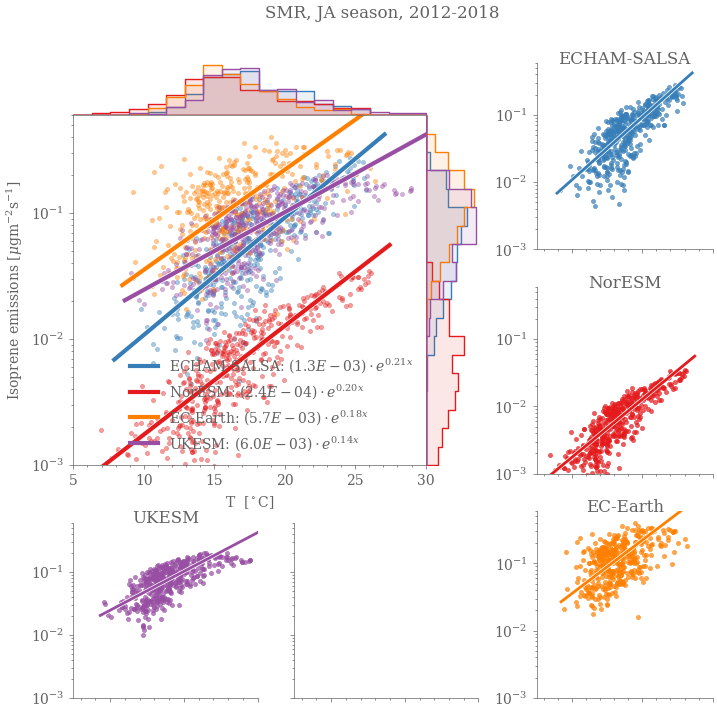

<Figure size 700x525 with 0 Axes>

<Figure size 700x525 with 0 Axes>

<Figure size 700x525 with 0 Axes>

<Figure size 700x525 with 0 Axes>

In [64]:
fig, ax, daxs, axs_extra = make_cool_grid5()##ncols_extra=2, nrows_extra=2,)# w_ratio_sideplot=.5)
axs_extra = axs_extra.flatten()

## Settings
alpha_scatt = 0.6

xlab = r'T  [$^\circ$C]'
ylab = r'Isoprene emissions [$\mu$gm$^{-2}$s$^{-1}$]'#[$\mu g m^{-3}$]'


linewidth=2
xlims =[5,30]
ylims = [1e-3,6e-1]


season='JA'
v_x = 'T_C'
v_y = 'emiisop'


make_plot(v_x, v_y, xlims, ylims, season, 
              xlab, ylab, .3, models, fig, ax, daxs, axs_extra,
          yscale='log',
          dic_df_med = dic_df_med,
          #source_list = models
         
         )


for mo, ax_ex in zip(models, axs_extra[:]):
    print(mo)
    df_s =  dic_df_med[mo]
    print(mo)
    mask_months = select_months(df_s, season=season)
    df_s = df_s[mask_months].copy()
    popt, pov, label, func = get_odr_fit_and_labs(df_s, v_x, v_y, fit_func = 'exp', return_func=True, beta0=[0.01,.12])
    _mi = df_s[v_x].min()
    _ma = df_s[v_x].max() 
    _xlim = [_mi*.95, _ma*1.05]
    x = np.linspace(*_xlim)
    
    ax.plot(x, func(x, *popt), c='w', linewidth=linewidth+2,label='__nolegend__')
    ax.plot(x, func(x, *popt), linewidth=linewidth+1, c=cdic_model[mo],label=f'{mo}: {label}')

    ax_ex.plot(x, func(x, *popt), c='w', linewidth=linewidth+1,label=f'{mo}: {label}',
             )
    ax_ex.plot(x, func(x, *popt), c=cdic_model[mo],label=f'{mo}: {label}',
               linewidth=linewidth,
              )
    ax_ex.set_yscale('log')
ax.set_yscale('log')


    
fn = make_fn_scat(f'exp1_{season}', v_x, v_y)
ax.legend(frameon=False)
fig.savefig(fn, dpi=150)
fig.savefig(fn.with_suffix('.pdf'), dpi=150)
print(fn)


plt.show()

ECHAM-SALSA
NorESM
EC-Earth
UKESM
ECHAM-SALSA
(0.0, 77.7)
NorESM
(0.0, 77.7)
EC-Earth
(0.0, 88.2)
UKESM
(0.0, 88.2)
ECHAM-SALSA
ECHAM-SALSA
[0.01, 0.12]
Beta: [0.00396702 0.11592575]
Beta Std Error: [0.00013837 0.00181634]
Beta Covariance: [[ 4.30584933e-07 -5.57174330e-06]
 [-5.57174330e-06  7.41988120e-05]]
Residual Variance: 0.04446308636503426
Inverse Condition #: 0.08236329120466264
Reason(s) for Halting:
  Sum of squares convergence
[0.00396702 0.11592575]
reason for halting
NorESM
NorESM
[0.01, 0.12]
Beta: [0.00500524 0.12177297]
Beta Std Error: [0.00016868 0.00180657]
Beta Covariance: [[ 7.80477107e-07 -8.18750017e-06]
 [-8.18750017e-06  8.95263382e-05]]
Residual Variance: 0.03645520037323466
Inverse Condition #: 0.09887904481226249
Reason(s) for Halting:
  Sum of squares convergence
[0.00500524 0.12177297]
reason for halting
EC-Earth
EC-Earth
[0.01, 0.12]
Beta: [0.00333011 0.11391866]
Beta Std Error: [0.00036294 0.00623749]
Beta Covariance: [[ 3.01729092e-07 -5.11950276e-06]
 

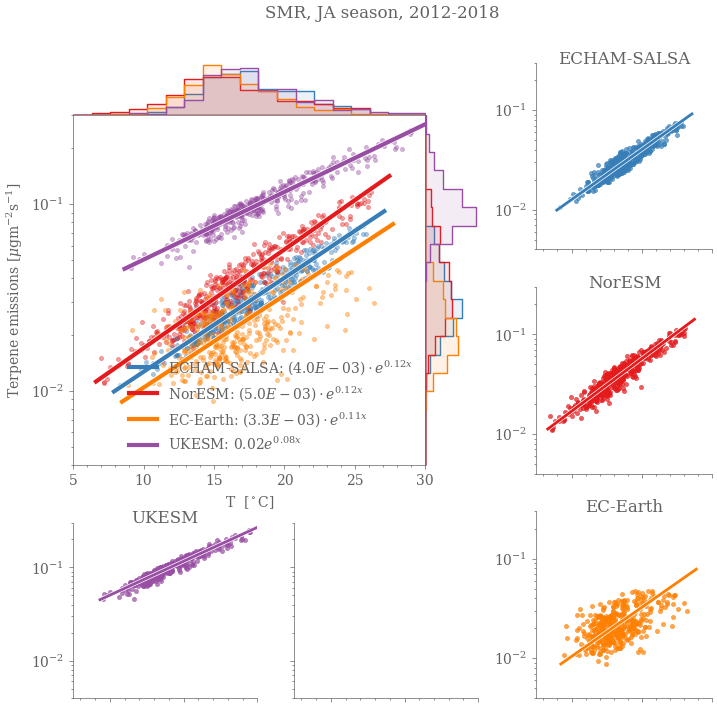

<Figure size 700x525 with 0 Axes>

<Figure size 700x525 with 0 Axes>

<Figure size 700x525 with 0 Axes>

<Figure size 700x525 with 0 Axes>

In [65]:
fig, ax, daxs, axs_extra = make_cool_grid5()##ncols_extra=2, nrows_extra=2,)# w_ratio_sideplot=.5)
axs_extra = axs_extra.flatten()

## Settings
alpha_scatt = 0.6

xlab = r'T  [$^\circ$C]'
ylab = r'Terpene emissions [$\mu$gm$^{-2}$s$^{-1}$]'#[$\mu g m^{-3}$]'


linewidth=2
xlims =[5,30]
ylims = [4e-3,3e-1]


season='JA'
v_x = 'T_C'
v_y = 'emiterp'


make_plot(v_x, v_y, xlims, ylims, season, 
              xlab, ylab, .3, models, fig, ax, daxs, axs_extra,
          yscale='log',
          dic_df_med = dic_df_med,
          #source_list = models
         
         )


for mo, ax_ex in zip(models, axs_extra[:]):
    print(mo)
    df_s =  dic_df_med[mo]
    print(mo)
    mask_months = select_months(df_s, season=season)
    df_s = df_s[mask_months].copy()
    popt, pov, label, func = get_odr_fit_and_labs(df_s, v_x, v_y, fit_func = 'exp', return_func=True, beta0=[0.01,.12])
    _mi = df_s[v_x].min()
    _ma = df_s[v_x].max() 
    _xlim = [_mi*.95, _ma*1.05]
    x = np.linspace(*_xlim)
    
    ax.plot(x, func(x, *popt), c='w', linewidth=linewidth+2,label='__nolegend__')
    ax.plot(x, func(x, *popt), linewidth=linewidth+1, c=cdic_model[mo],label=f'{mo}: {label}')

    ax_ex.plot(x, func(x, *popt), c='w', linewidth=linewidth+1,label=f'{mo}: {label}',
             )
    ax_ex.plot(x, func(x, *popt), c=cdic_model[mo],label=f'{mo}: {label}',
               linewidth=linewidth,
              )
    ax_ex.set_yscale('log')
ax.set_yscale('log')


    
fn = make_fn_scat(f'exp1_{season}', v_x, v_y)
ax.legend(frameon=False)
fig.savefig(fn, dpi=150)
fig.savefig(fn.with_suffix('.pdf'), dpi=150)

print(fn)


plt.show()

ECHAM-SALSA
NorESM
EC-Earth
UKESM
ECHAM-SALSA
(0.0, 219.45)
NorESM
(0.0, 219.45)
EC-Earth
(0.0, 222.6)
UKESM
(0.0, 222.6)
ECHAM-SALSA
ECHAM-SALSA
NorESM
NorESM
EC-Earth
EC-Earth
UKESM
UKESM
Plots/SMR/scat_all_years_echam_noresm_exp1_JA_emiterp_OA-SMR_ukesm.png


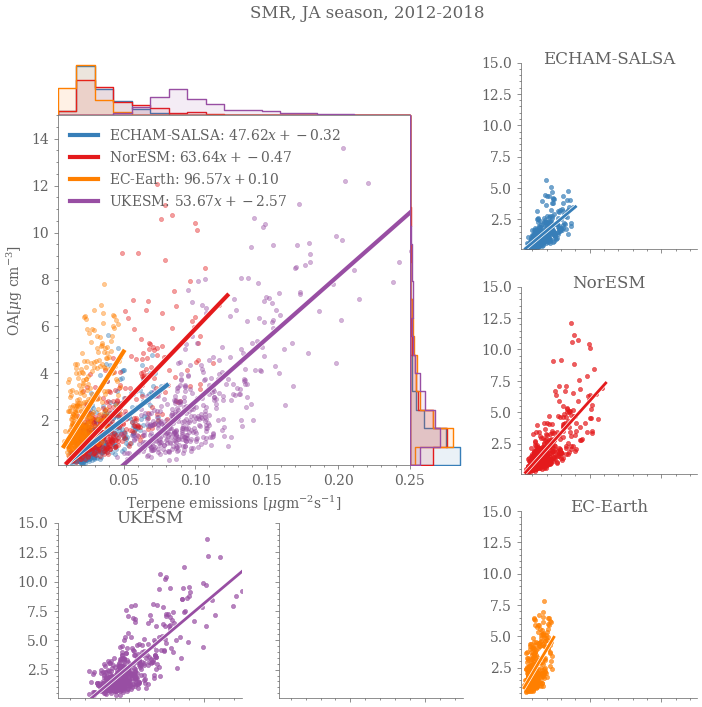

<Figure size 700x525 with 0 Axes>

<Figure size 700x525 with 0 Axes>

<Figure size 700x525 with 0 Axes>

<Figure size 700x525 with 0 Axes>

In [66]:
fig, ax, daxs, axs_extra = make_cool_grid5()##ncols_extra=2, nrows_extra=2,)# w_ratio_sideplot=.5)
axs_extra = axs_extra.flatten()

## Settings
alpha_scatt = 0.6

xlab = r'Terpene emissions [$\mu$gm$^{-2}$s$^{-1}$]'#[$\mu g m^{-3}$]'

ylab = r'OA[$\mu$g cm$^{-3}$]'#[$\mu g m^{-3}$]'


linewidth=2
lims =[5,30]
xlims = [4e-3,2.5e-1]
ylims = [1e-1,15]


season='JA'
v_x = 'emiterp'
v_y = 'OA'


make_plot(v_x, v_y, xlims, ylims, season, 
              xlab, ylab, .3, models, fig, ax, daxs, axs_extra,
          yscale='linear',
          dic_df_med = dic_df_med,
          #source_list = models
         
         )


for mo, ax_ex in zip(models, axs_extra[:]):
    print(mo)
    df_s =  dic_df_med[mo]
    print(mo)
    mask_months = select_months(df_s, season=season)
    df_s = df_s[mask_months].copy()
    if 'emi' in v_y:
        df_s = df_s[df_s[v_y]>0]
    df_s = df_s[df_s[[v_x,v_y]].notna().all(axis=1)]
    #popt, pov, label, func = get_odr_fit_and_labs(df_s, v_x, v_y, fit_func = 'exp', return_func=True, beta0=[0.01,.12])
    #popt, pov, label, func,func_lin, popt_lin = get_lin_log_fit(df_s, v_x, v_y, fit_func = 'exp', return_func=True, beta0=[0.01,.12])
    popt, pov, label, func= get_linear_fit(df_s, v_x, v_y,  return_func=True,)# beta0=[0.01,.12])

    _mi = df_s[v_x].min()
    _ma = df_s[v_x].max() 
    _xlim = [_mi*.95, _ma*1.05]
    x = np.linspace(*_xlim)
    
    ax.plot(x, func(x, *popt), c='w', linewidth=linewidth+2,label='__nolegend__')
    ax.plot(x, func(x, *popt), linewidth=linewidth+1, c=cdic_model[mo],label=f'{mo}: {label}')

    ax_ex.plot(x, func(x, *popt), c='w', linewidth=linewidth+1,label=f'{mo}: {label}',
             )
    ax_ex.plot(x, func(x, *popt), c=cdic_model[mo],label=f'{mo}: {label}',
               linewidth=linewidth,
              )
    ax_ex.set_yscale('linear')
ax.set_yscale('linear')
ax.set_xscale('linear')


    
fn = make_fn_scat(f'exp1_{season}', v_x, v_y)
ax.legend(frameon=False)
fig.savefig(fn, dpi=150)
fig.savefig(fn.with_suffix('.pdf'), dpi=150)

print(fn)


plt.show()

ECHAM-SALSA
NorESM
EC-Earth
UKESM
ECHAM-SALSA
(0.0, 91.35)
NorESM
(0.0, 388.5)
EC-Earth
(0.0, 388.5)
UKESM
(0.0, 388.5)
ECHAM-SALSA
ECHAM-SALSA
NorESM
NorESM
EC-Earth
EC-Earth
UKESM
UKESM
Plots/SMR/scat_all_years_echam_noresm_exp1_JA_emiisop_OA-SMR_ukesm.png


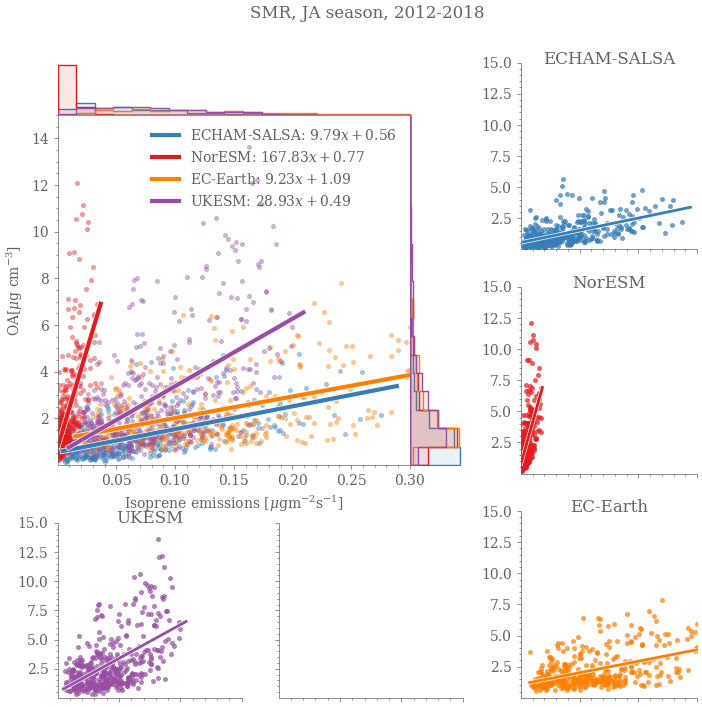

<Figure size 700x525 with 0 Axes>

<Figure size 700x525 with 0 Axes>

<Figure size 700x525 with 0 Axes>

<Figure size 700x525 with 0 Axes>

In [67]:
fig, ax, daxs, axs_extra = make_cool_grid5()##ncols_extra=2, nrows_extra=2,)# w_ratio_sideplot=.5)
axs_extra = axs_extra.flatten()

## Settings
alpha_scatt = 0.6

xlab = r'Isoprene emissions [$\mu$gm$^{-2}$s$^{-1}$]'#[$\mu g m^{-3}$]'

ylab = r'OA[$\mu$g cm$^{-3}$]'#[$\mu g m^{-3}$]'


linewidth=2
lims =[5,30]
xlims = [1e-9,3e-1]
ylims = [1e-8,15]


season='JA'
v_x = 'emiisop'
v_y = 'OA'


make_plot(v_x, v_y, xlims, ylims, season, 
              xlab, ylab, .3, models, fig, ax, daxs, axs_extra,
          yscale='linear',
          dic_df_med = dic_df_med,
          #source_list = models
         
         )


for mo, ax_ex in zip(models, axs_extra[:]):
    print(mo)
    df_s =  dic_df_med[mo]
    print(mo)
    mask_months = select_months(df_s, season=season)
    df_s = df_s[mask_months].copy()
    if 'emi' in v_y:
        df_s = df_s[df_s[v_y]>0]
    df_s = df_s[df_s[[v_x,v_y]].notna().all(axis=1)]
    #popt, pov, label, func = get_odr_fit_and_labs(df_s, v_x, v_y, fit_func = 'exp', return_func=True, beta0=[0.01,.12])
    popt, pov, label, func= get_linear_fit(df_s, v_x, v_y,  return_func=True,)# beta0=[0.01,.12])

    _mi = df_s[v_x].min()
    _ma = df_s[v_x].max() 
    _xlim = [_mi*.95, _ma*1.05]
    x = np.linspace(*_xlim)
    
    ax.plot(x, func(x, *popt), c='w', linewidth=linewidth+2,label='__nolegend__')
    ax.plot(x, func(x, *popt), linewidth=linewidth+1, c=cdic_model[mo],label=f'{mo}: {label}')

    ax_ex.plot(x, func(x, *popt), c='w', linewidth=linewidth+1,label=f'{mo}: {label}',
             )
    ax_ex.plot(x, func(x, *popt), c=cdic_model[mo],label=f'{mo}: {label}',
               linewidth=linewidth,
              )
    ax_ex.set_yscale('linear')
ax.set_yscale('linear')
ax.set_xscale('linear')


    
fn = make_fn_scat(f'exp1_{season}', v_x, v_y)
ax.legend(frameon=False)
fig.savefig(fn, dpi=150)
fig.savefig(fn.with_suffix('.pdf'), dpi=150)

print(fn)


plt.show()

In [68]:
from matplotlib import colors

ECHAM-SALSA
ECHAM-SALSA
0.5637184105102458
NorESM
NorESM
0.6394824105174819
EC-Earth
EC-Earth
0.4957191851056482
UKESM
UKESM
0.5573488673571826
ECHAM-SALSA
ECHAM-SALSA
0.6748743499626975
NorESM
NorESM
0.7173166149714261
EC-Earth
EC-Earth
0.5645076235497378
UKESM
UKESM
0.7805971594399698


/tmp/ipykernel_73628/3925448562.py:71: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  f.tight_layout()
No handles with labels found to put in legend.


Plots/SMR/scat_all_years_echam_noresm_scatter_JA_emiisop_emiterp_zyear_emiisop_OA-SMR_ukesm.png


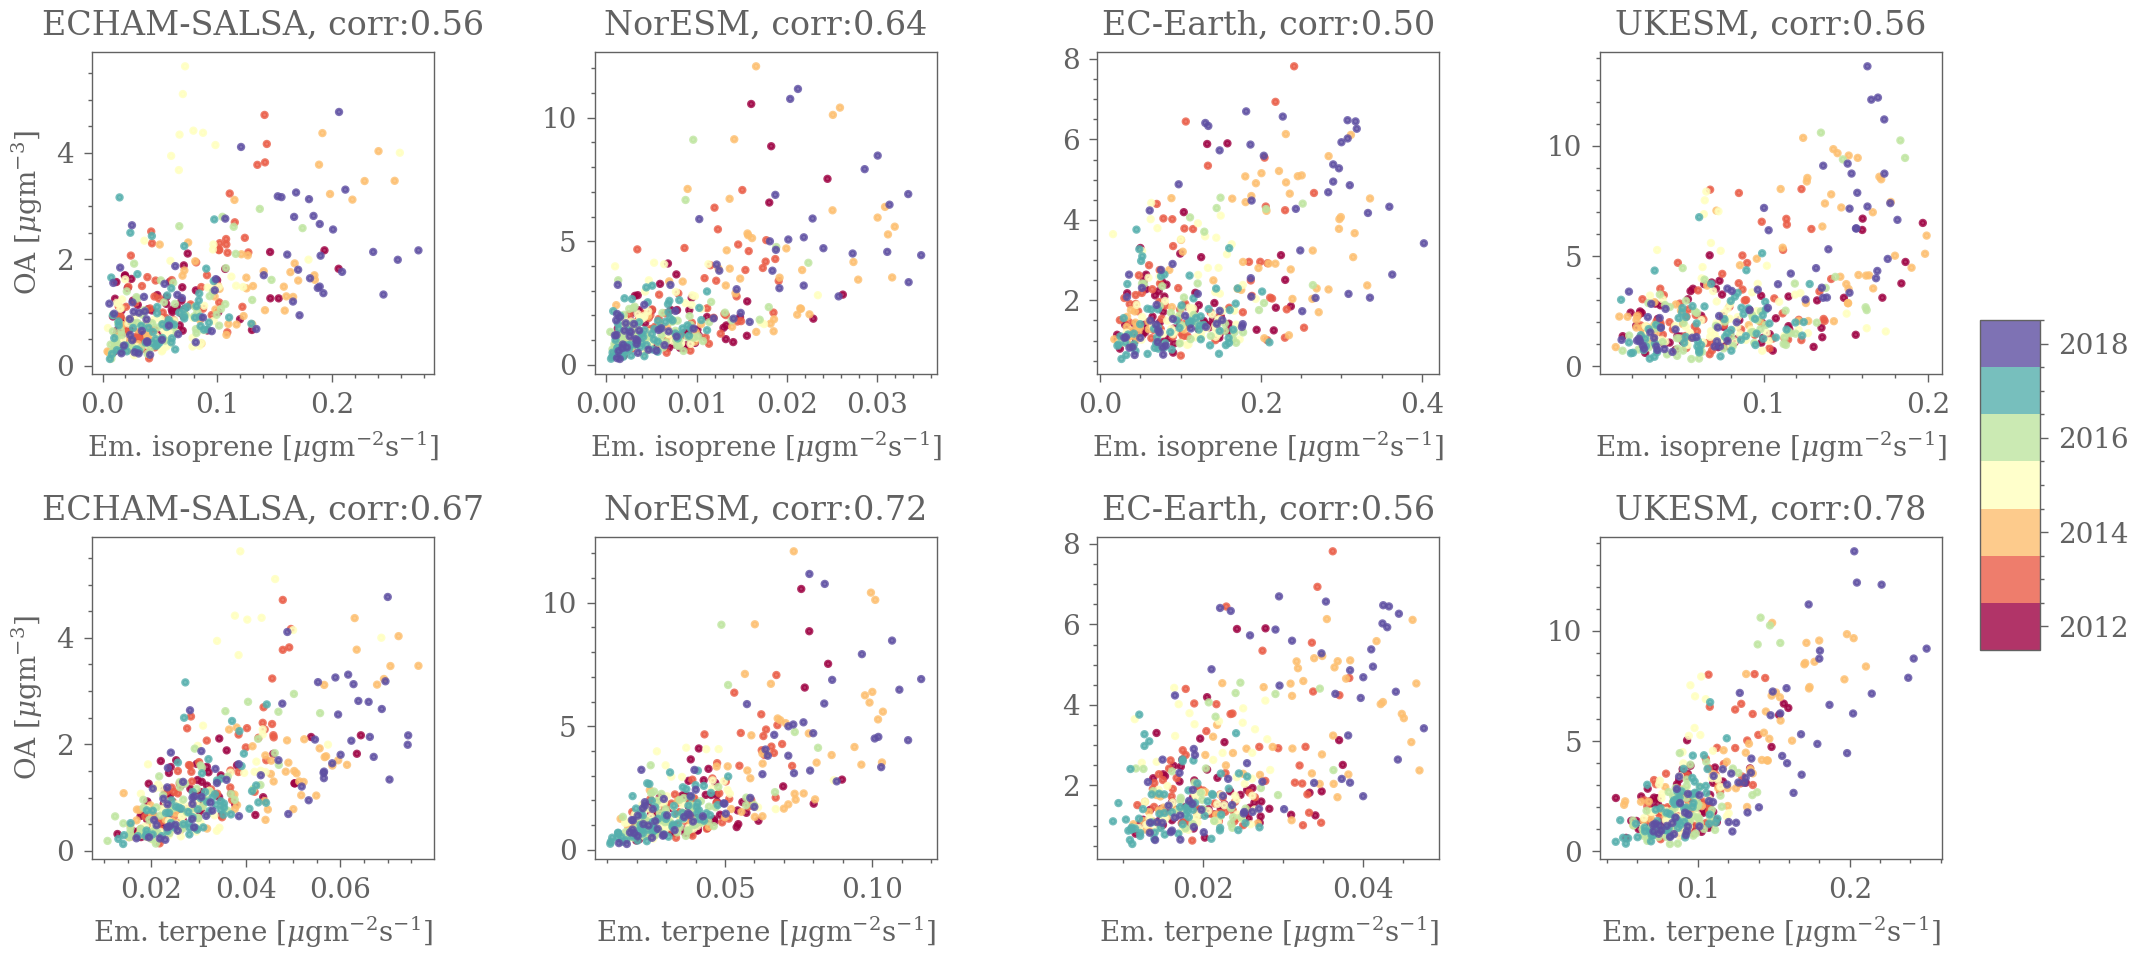

In [114]:
y_lab = 'OA [$\mu$gm$^{-3}$]'
v_x1 = 'emiisop'
v_x2 = 'emiterp'

x_lab1 = 'Em. isoprene [$\mu$gm$^{-2}$s$^{-1}$]'
x_lab2 = 'Em. terpene [$\mu$gm$^{-2}$s$^{-1}$]'

v_y = 'OA'
v_z = 'year'
season = 'JA'
f, axs_extra = plt.subplots(2,4, figsize=[10,5])

def do_it(v_x,v_y, v_z, axs, xlab, ylab):

    for mo, ax in zip(models, axs):
        print(mo)
        df_mo =  dic_df_med[mo]
        print(mo)
        mask_months = select_months(df_mo, season=season)
        df_mo = df_mo[mask_months].copy()

        s = ax.scatter(df_mo[v_x],df_mo[v_y], 
               edgecolor=None, 
               alpha=.8, 
               c=df_mo[v_z], 
                   s=4,
               cmap=plt.cm.get_cmap('Spectral', lut=7),
                   norm = colors.Normalize(
                   vmin=2011.5,
                   vmax=2018.5,
                   )
              )
        _co = df_mo[v_x].corr( df_mo[v_y])
        print(_co)
        #ax.text(0.1,8, f'corr:{_co:.2f}')
        #ax.set_title(mo)
        ax.set_title(f'{mo}, corr:{_co:.2f}')
    
        ax.set_ylabel(v_y)
        if xlab is None:
            ax.set_xlabel(v_x)
        else:
            ax.set_xlabel(xlab)
        if ylab is None:
            ax.set_ylabel(v_y)
        else:
            ax.set_ylabel(ylab)
            
            
    return s 

################################
axs = axs_extra[0,:]
v_x = v_x1
x_lab = x_lab1
s = do_it(v_x,v_y, v_z, axs, x_lab, ylab)
    
################################
    
################################

axs = axs_extra[1,:]
v_x = v_x2
x_lab = x_lab2
#s = do_it(v_x2,v_y, v_z, axs)
s = do_it(v_x,v_y, v_z, axs, x_lab, ylab)
################################

cbar_ax = f.add_axes([1, 0.33, 0.03, 0.33])
f.colorbar(s, cax=cbar_ax)
f.tight_layout()
for ax in axs_extra.flatten():
    ax.set_xlabel('')
    ax.set_ylabel('')
for ax in axs_extra[0,:]:
    ax.set_xlabel(x_lab1)

for ax in axs_extra[1,:]:
    ax.set_xlabel(x_lab2)

axs_extra[0,0].set_ylabel(y_lab)
axs_extra[1,0].set_ylabel(y_lab)


ax.legend(frameon=False)
fn = make_fn_scat(f'scatter_{season}_{v_x1}_{v_x2}_z{v_z}', v_x1, v_y)

f.savefig(fn, dpi=150, bbox_inches="tight")
f.savefig(fn.with_suffix('.pdf'), dpi=150,bbox_inches="tight")

print(fn) 

plt.show()

ECHAM-SALSA
ECHAM-SALSA
0.8192966184620238
NorESM
NorESM
0.8672345845012914
EC-Earth
EC-Earth
0.5116209538312018
UKESM
UKESM
0.7463871698574476
ECHAM-SALSA
ECHAM-SALSA
0.9331905536162077
NorESM
NorESM
0.9335571316938187
EC-Earth
EC-Earth
0.5513407534528854
UKESM
UKESM
0.953870078117926


/tmp/ipykernel_73628/982941766.py:66: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  f.tight_layout()
No handles with labels found to put in legend.


Plots/SMR/scat_all_years_echam_noresm_scatter_JA_T_C_zyear_emiisop_emiterp-SMR_ukesm.png


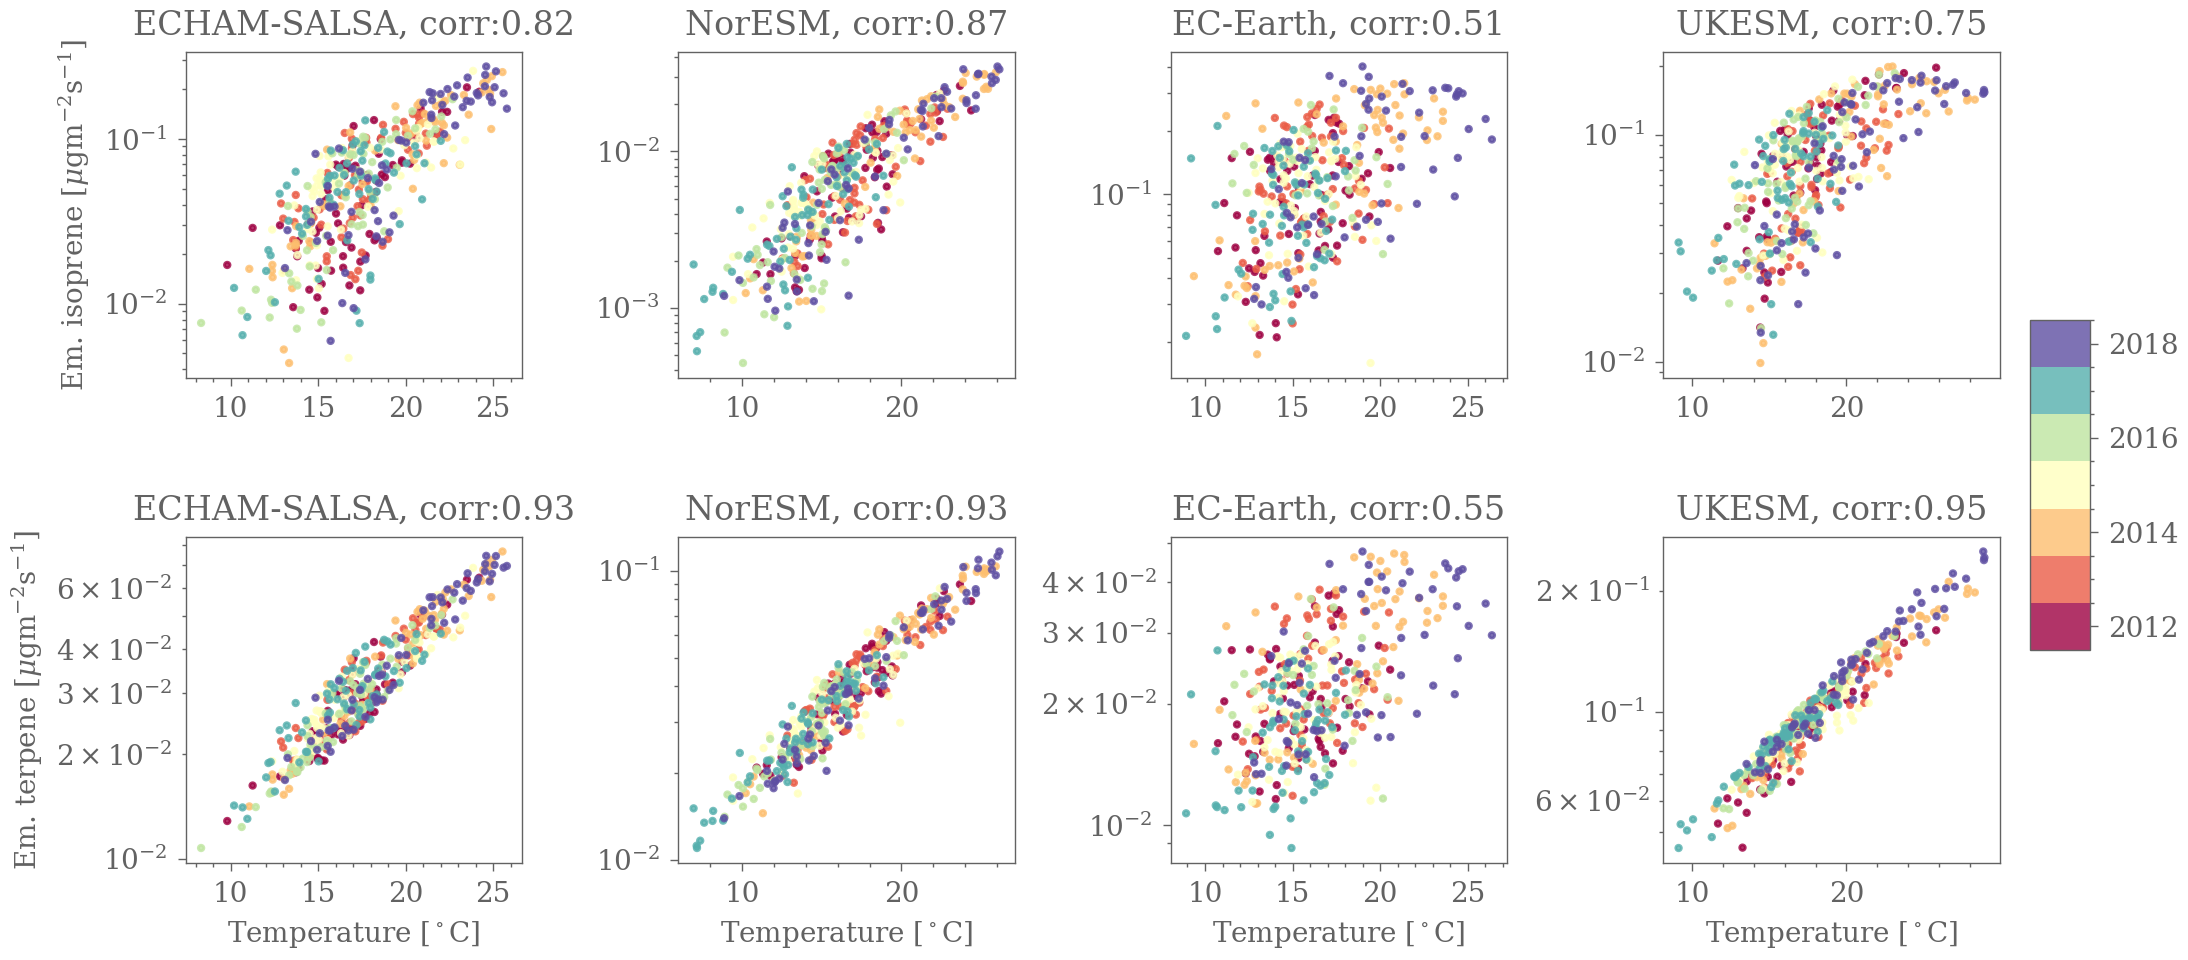

In [116]:
v_x = 'T_C'
v_y1 = 'emiisop'
v_y2 = 'emiterp'
y_lab1 = 'Em. isoprene [$\mu$gm$^{-2}$s$^{-1}$]'
y_lab2 = 'Em. terpene [$\mu$gm$^{-2}$s$^{-1}$]'
x_lab = 'Temperature [$^\circ$C]'
v_z = 'year'

season = 'JA'
f, axs_extra = plt.subplots(2,4, figsize=[10,5])

def do_it(v_x,v_y, v_z, axs, xlab, ylab):

    for mo, ax in zip(models, axs):
        print(mo)
        df_mo =  dic_df_med[mo]
        print(mo)
        mask_months = select_months(df_mo, season=season)
        df_mo = df_mo[mask_months].copy()

        s = ax.scatter(df_mo[v_x],df_mo[v_y], 
               edgecolor=None, 
               alpha=.8, 
               c=df_mo[v_z], 
                   s=4,
               cmap=plt.cm.get_cmap('Spectral', lut=7),
                   norm = colors.Normalize(
                   vmin=2011.5,
                   vmax=2018.5,
                   )
              )
        _co = df_mo[v_x].corr( df_mo[v_y])
        print(_co)
        #ax.text(0.1,8, f'corr:{_co:.2f}')
        #ax.set_title(mo)
        ax.set_title(f'{mo}, corr:{_co:.2f}')
    
        ax.set_ylabel(v_y)
        if xlab is None:
            ax.set_xlabel(v_x)
        else:
            ax.set_xlabel(xlab)
        if ylab is None:
            ax.set_ylabel(v_y)
        else:
            ax.set_ylabel(ylab)
            
            
    return s 

####################################
axs = axs_extra[0,:]
v_y = v_y1
y_lab = y_lab1
s = do_it(v_x,v_y, v_z, axs, x_lab, y_lab)
    
####################################
v_y = v_y2
y_lab = y_lab2
axs = axs_extra[1,:]
#s = do_it(v_x2,v_y, v_z, axs)
s = do_it(v_x,v_y, v_z, axs, x_lab, y_lab)
####################################
cbar_ax = f.add_axes([1, 0.33, 0.03, 0.33])
f.colorbar(s, cax=cbar_ax)
f.tight_layout()


ax.legend(frameon=False)
fn = make_fn_scat(f'scatter_{season}_{v_x}_z{v_z}', v_y1, v_y2)
for ax in axs_extra.flatten():
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_yscale('log')
for ax in axs_extra[1,:]:
    ax.set_xlabel(x_lab)

axs_extra[0,0].set_ylabel(y_lab1)
axs_extra[1,0].set_ylabel(y_lab2)



f.savefig(fn, dpi=150, bbox_inches="tight")
f.savefig(fn.with_suffix('.pdf'), dpi=150,bbox_inches="tight")

print(fn) 

plt.show()

In [108]:
from bs_fdbck_clean.util.plot.plot_settings import insert_abc_axs

T_C emiisop
FSDS_DRF emiisop
T_C emiterp
FSDS_DRF emiterp


/tmp/ipykernel_73628/1642617984.py:116: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Plots/SMR/scat_all_years_echam_noresm_scatter_JA_T_C_FSDS_DRF_zyear_T_C_emiterp-SMR_ukesm.png


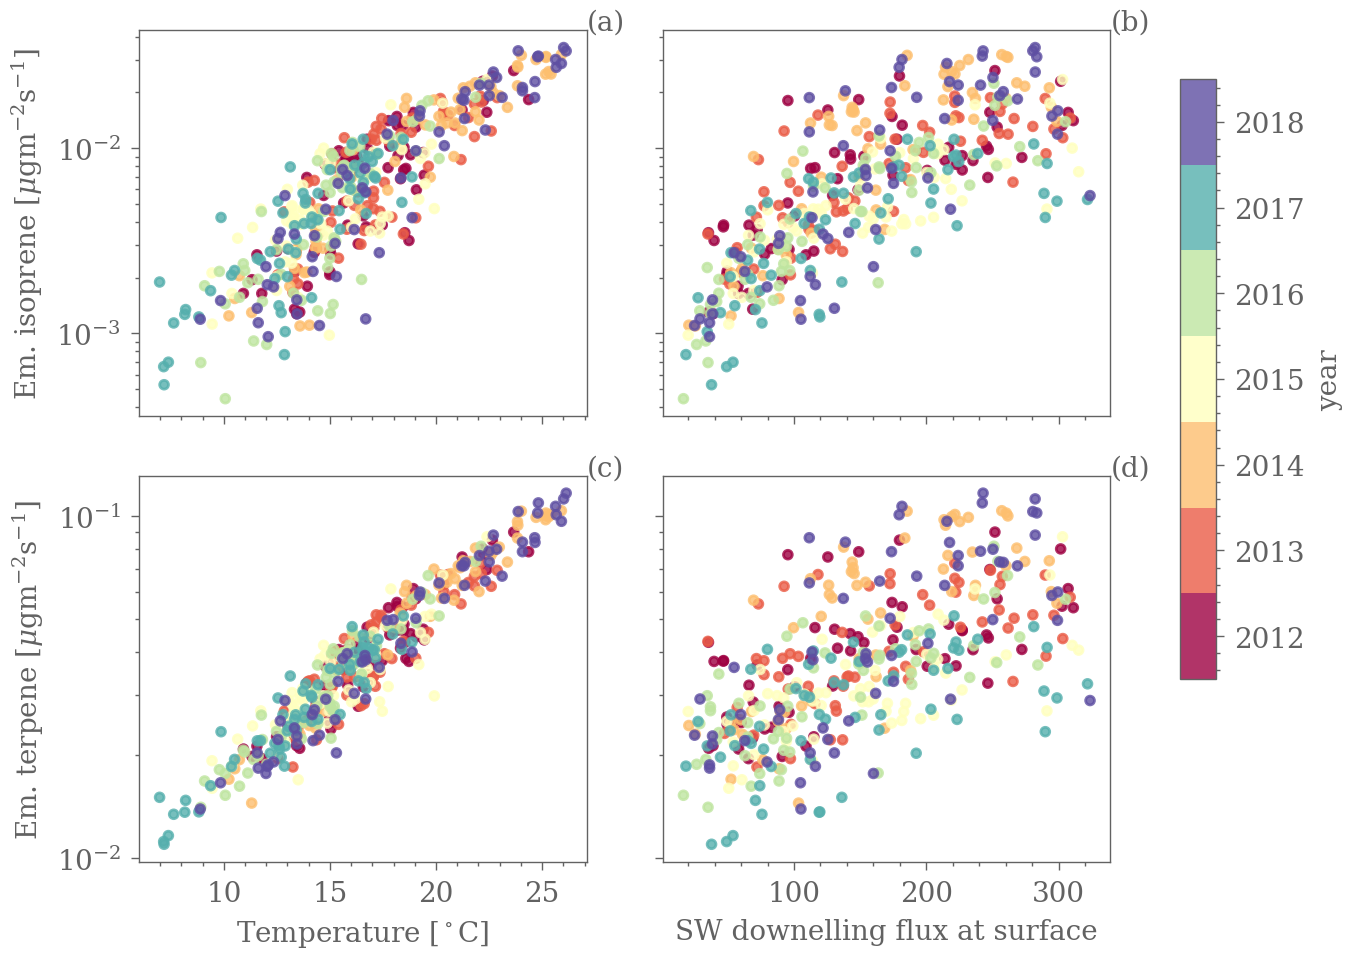

In [112]:
model_name = 'NorESM'
fig, axs = plt.subplots(2,2, figsize = [6,5], sharey='row', sharex='col')
axs = axs

## Settings
alpha_scatt = 0.6
linewidth=2
season='JA'

    

df_mo = dic_df_med[model_name]
mask_months = select_months(df_mo, season=season)
df_mo = df_mo[mask_months].copy()

def do_it(v_x, v_y, v_z, lab_x, lab_y,lab_z, ax):
    s = ax.scatter(df_mo[v_x],df_mo[v_y], edgecolor=None, alpha=.8, 
               c=df_mo[v_z], 
               #cmap=plt.cm.get_cmap('Reds', lut=8),
               #norm=colors.LogNorm(1,200, )#,extend='both'
               s=10,
               
               cmap=plt.cm.get_cmap('Spectral', lut=7),
               norm = colors.Normalize(
                   vmin=2011.5,
                   vmax=2018.5,
                   )

              )

    return s





#df_mo = df_mo.loc['2015':None,:]
v_x1 = 'T_C'    
v_x2 = 'FSDS_DRF'
v_y1 = 'emiisop'    
v_y2 = 'emiterp'

xlab1 = 'Temperature [$^\circ$C]'
xlab2 = 'SW downelling flux at surface'
ylab1 = 'Em. isoprene [$\mu$gm$^{-2}$s$^{-1}$]'
ylab2 = 'Em. terpene [$\mu$gm$^{-2}$s$^{-1}$]'
v_z = 'year'

lab_z = v_z#'SW radiation surf [Wm$^{-2}$]'


########################
v_x = v_x1
v_y = v_y1
lab_x = xlab1
lab_y = ylab1
ax = axs[0,0]
print(v_x,v_y)
do_it(v_x, v_y, v_z, lab_x, lab_y,lab_z, ax)
ax.set_yscale('log')
#ax.set_xlabel(lab_x)
ax.set_ylabel(lab_y)

########################
########################
v_x = v_x2
v_y = v_y1
lab_x = xlab2
lab_y = ylab1
ax = axs[0,1]
print(v_x,v_y)
do_it(v_x, v_y, v_z, lab_x, lab_y,lab_z, ax)
#ax.set_xlabel(lab_x)
#ax.set_ylabel(lab_y)

ax.set_yscale('log')
ax.set_xscale('linear')
########################

########################
v_x = v_x1
v_y = v_y2
lab_x = xlab1
lab_y = ylab2
ax = axs[1,0]
print(v_x,v_y)
do_it(v_x, v_y, v_z, lab_x, lab_y,lab_z, ax)
ax.set_yscale('log')
ax.set_xlabel(lab_x)
ax.set_ylabel(lab_y)

########################
########################
v_x = v_x2
v_y = v_y2
lab_x = xlab2
lab_y = ylab2
ax = axs[1,1]
print(v_x,v_y)
do_it(v_x, v_y, v_z, lab_x, lab_y,lab_z, ax)

ax.set_yscale('log')
ax.set_xscale('linear')
ax.set_xlabel(lab_x)
#ax.set_ylabel(lab_y)

########################


cbar_ax = fig.add_axes([1, 0.3, 0.03, 0.6])
fig.colorbar(s,label=lab_z, cax=cbar_ax)


fn = make_fn_scat(f'scatter_{season}_{v_x1}_{v_x2}_z{v_z}', v_x1, v_y)
insert_abc_axs(axs,)# scale_1=0, scale_2=.5)
plt.tight_layout()

print(fn)
fig.savefig(fn, dpi=150, bbox_inches="tight")
fig.savefig(fn.with_suffix('.pdf'), dpi=150,bbox_inches="tight")


plt.show()


No handles with labels found to put in legend.


ECHAM-SALSA
ECHAM-SALSA
NorESM
NorESM
EC-Earth
EC-Earth
UKESM
UKESM
ECHAM-SALSA
ECHAM-SALSA
NorESM
NorESM
EC-Earth
EC-Earth
UKESM
UKESM
Plots/SMR/scat_all_years_echam_noresm_correlation_through_year_emiterp_OA_emiisop-SMR_ukesm.png


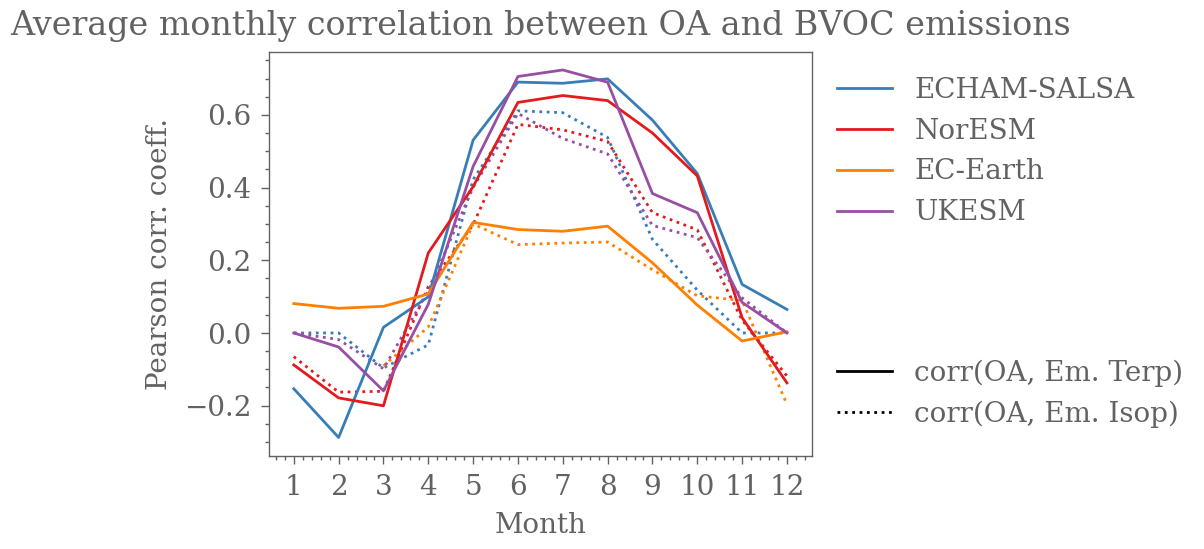

In [113]:
from matplotlib.lines import Line2D
fig, ax = plt.subplots()

v_x ='OA'
v_y='emiisop'
v_y2='emiterp'


for mo in models:
    print(mo)
    df_s =  dic_df_med[mo]
    print(mo)
    _df_cov = df_s[v_y].rolling(30).corr(df_s[v_x])#.groupby('m').mean()#.plot()
    _df_cov.groupby(_df_cov.index.month).mean().plot(label='__nolabel__', c= cdic_model[mo], linestyle=':')
plt.legend()

lines = []
for mo in models:
    print(mo)
    df_s =  dic_df_med[mo]
    print(mo)
    _df_cov = df_s[v_y2].rolling(30).corr(df_s[v_x])#.groupby('m').mean()#.plot()
    l = _df_cov.groupby(_df_cov.index.month).mean().plot(label=mo, c= cdic_model[mo])
    lines.append(l)

    
    
leg1 = ax.legend(bbox_to_anchor=(1,1,))
custom_lines = [Line2D([0], [0], color='k',linestyle='solid', lw=1),
                Line2D([0], [0], color='k',linestyle=':', lw=1)]

ax.legend(custom_lines, ['corr(OA, Em. Terp)','corr(OA, Em. Isop)'], bbox_to_anchor=(1,.3,))

ax.add_artist(leg1)
plt.title(f'Average monthly correlation between OA and BVOC emissions')
plt.ylabel('Pearson corr. coeff.')
plt.xlabel('Month')
ax.set_xticks(np.arange(1,13))

fn = make_fn_scat(f'correlation_through_year_{v_y2}', v_x, v_y)
fig.savefig(fn, dpi=150, bbox_inches="tight")
fig.savefig(fn.with_suffix('.pdf'), dpi=150,bbox_inches="tight")

print(fn)

emiisop oh_con
emiterp oh_con
emiisop VBS0_gas_conc
emiterp VBS0_gas_conc
Plots/SMR/scat_all_years_echam_noresm_scatter_JA_emiisop_emiterp_zyear_emiisop_VBS0_gas_conc-SMR_ukesm.png


/tmp/ipykernel_73628/434151920.py:118: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


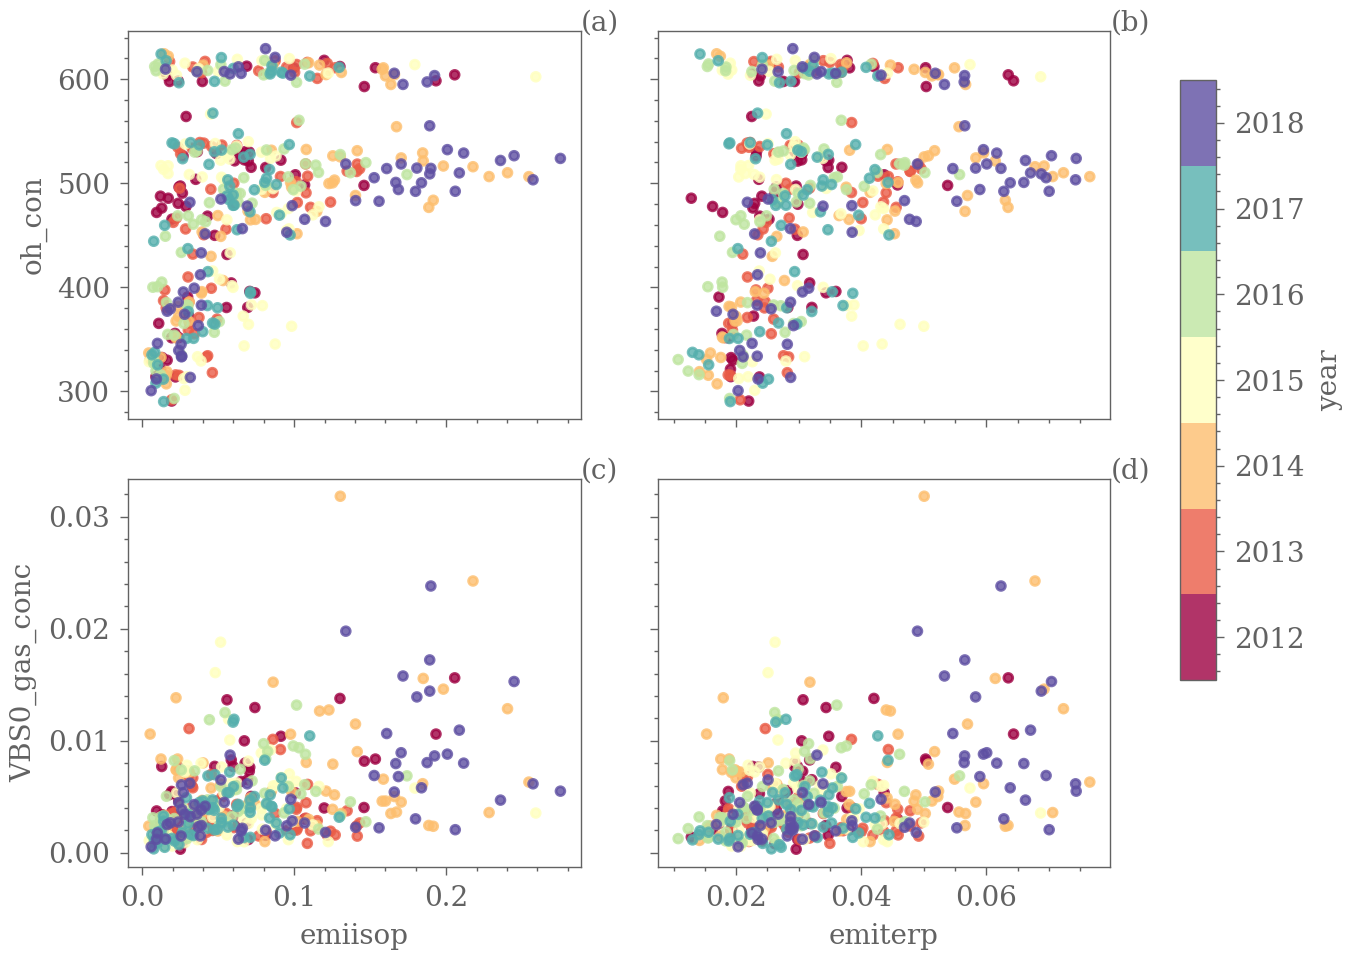

In [117]:
model_name = 'ECHAM-SALSA'
fig, axs = plt.subplots(2,2, figsize = [6,5], sharey='row', sharex='col')
axs = axs

## Settings
alpha_scatt = 0.6
linewidth=2
season='JA'

    

df_mo = dic_df_med[model_name]
mask_months = select_months(df_mo, season=season)
df_mo = df_mo[mask_months].copy()

def do_it(v_x, v_y, v_z, lab_x, lab_y,lab_z, ax):
    s = ax.scatter(df_mo[v_x],df_mo[v_y], edgecolor=None, alpha=.8, 
               c=df_mo[v_z], 
               #cmap=plt.cm.get_cmap('Reds', lut=8),
               #norm=colors.LogNorm(1,200, )#,extend='both'
               s=10,
               
               cmap=plt.cm.get_cmap('Spectral', lut=7),
               norm = colors.Normalize(
                   vmin=2011.5,
                   vmax=2018.5,
                   )

              )

    return s





#df_mo = df_mo.loc['2015':None,:]
v_x1 = 'emiisop'    
v_x2 = 'emiterp'
v_y1 = 'oh_con'    
v_y2 = 'VBS0_gas_conc'

xlab1 = v_x1#'Temperature [$^\circ$C]'
xlab2 = v_x2#'SW downelling flux at surface'
ylab1 = v_y1#'Em. isoprene [$\mu$gm$^{-2}$s$^{-1}$]'
ylab2 = v_y2#'Em. terpene [$\mu$gm$^{-2}$s$^{-1}$]'
v_z = 'year'

lab_z = v_z#'SW radiation surf [Wm$^{-2}$]'


########################
v_x = v_x1
v_y = v_y1
lab_x = xlab1
lab_y = ylab1
ax = axs[0,0]
print(v_x,v_y)
do_it(v_x, v_y, v_z, lab_x, lab_y,lab_z, ax)
ax.set_yscale('linear')
#ax.set_xlabel(lab_x)
ax.set_ylabel(lab_y)

########################
########################
v_x = v_x2
v_y = v_y1
lab_x = xlab2
lab_y = ylab1
ax = axs[0,1]
print(v_x,v_y)
do_it(v_x, v_y, v_z, lab_x, lab_y,lab_z, ax)
#ax.set_xlabel(lab_x)
#ax.set_ylabel(lab_y)

ax.set_yscale('linear')
ax.set_xscale('linear')
########################

########################
v_x = v_x1
v_y = v_y2
lab_x = xlab1
lab_y = ylab2
ax = axs[1,0]
print(v_x,v_y)
do_it(v_x, v_y, v_z, lab_x, lab_y,lab_z, ax)
ax.set_yscale('linear')
ax.set_xlabel(lab_x)
ax.set_ylabel(lab_y)

########################
########################
v_x = v_x2
v_y = v_y2
lab_x = xlab2
lab_y = ylab2
ax = axs[1,1]
print(v_x,v_y)
do_it(v_x, v_y, v_z, lab_x, lab_y,lab_z, ax)

ax.set_yscale('linear')
ax.set_xscale('linear')
ax.set_xlabel(lab_x)
#ax.set_ylabel(lab_y)

########################


cbar_ax = fig.add_axes([1, 0.3, 0.03, 0.6])
fig.colorbar(s,label=lab_z, cax=cbar_ax)


fn = make_fn_scat(f'scatter_{season}_{v_x1}_{v_x2}_z{v_z}', v_x1, v_y)

print(fn)
insert_abc_axs(axs,)# scale_1=0, scale_2=.5)
plt.tight_layout()

#fig.savefig(fn, dpi=150, bbox_inches="tight")
#fig.savefig(fn.with_suffix('.pdf'), dpi=150,bbox_inches="tight")

plt.show()


In [70]:
def comp_OA(T, POA=10, alphac = 0.1, betac= .1):
    return POA + alphac*np.exp(betac*T)
def comp_OA_lin_temp(T,const=1, POA=10, alphac = 0.1, betac= .1):
    return POA*T + alphac*np.exp(betac*T)


In [71]:
temps = np.linspace(5,30)

[0.01, 0.12]
Beta: [2.8928572  0.06237914]
Beta Std Error: [0.10729998 0.00171874]
Beta Covariance: [[ 8.44887213e-01 -1.29302323e-02]
 [-1.29302323e-02  2.16781449e-04]]
Residual Variance: 0.013627010091213351
Inverse Condition #: 0.0003937507172584856
Reason(s) for Halting:
  Sum of squares convergence
[2.8928572  0.06237914]
reason for halting
$ 2.89 e^{ 0.06x}$


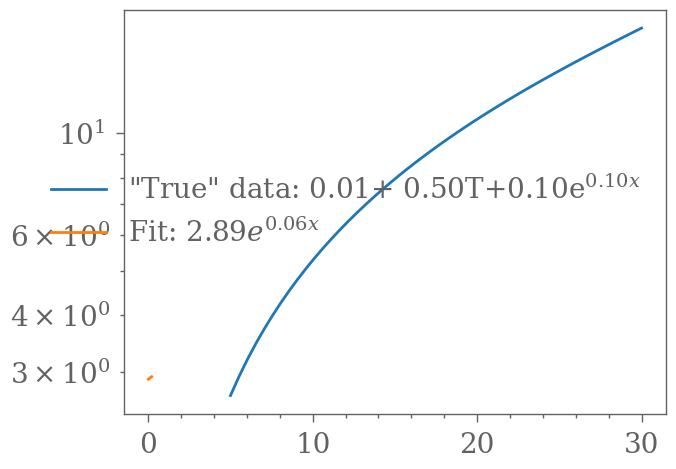

In [72]:
betac = 0.1
alphac=0.1
POA = .5
const = .01
OAs = comp_OA(temps, POA=POA, betac = betac, alphac =alphac)
OAs2 = comp_OA_lin_temp(temps,const=const, POA=POA, betac = betac, alphac =alphac)

_df = pd.DataFrame()
_df['T_C'] = temps
_df['dumb_OA'] = OAs2
plt.plot(temps, OAs2, label= r'"True" data: %.2f+ %.2fT+%.2fe$^{%.2f x}$'%(const,POA,alphac, betac))
plt.yscale('log')




popt, pov, label, func = get_odr_fit_and_labs(_df, 'T_C', 'dumb_OA', fit_func = 'exp', return_func=True, beta0=[0.01,.12])
print(label) 

plt.plot(x, func(x, *popt) ,label=f'Fit: {label}')
plt.legend()    

[0.01, 0.12]
Beta: [0.4217061  0.05673845]
Beta Std Error: [0.01022254 0.00111861]
Beta Covariance: [[ 0.01305929 -0.00135301]
 [-0.00135301  0.00015637]]
Residual Variance: 0.008001980674674499
Inverse Condition #: 0.002917884700091746
Reason(s) for Halting:
  Sum of squares convergence
[0.4217061  0.05673845]
reason for halting
$ 0.42 e^{ 0.06x}$


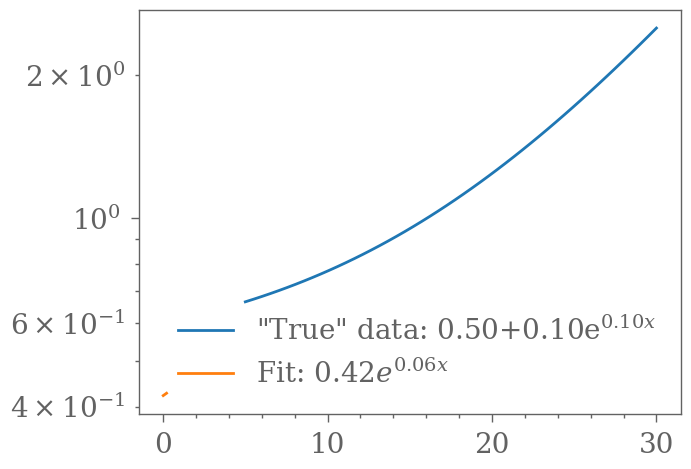

In [73]:
betac = 0.1
alphac=0.1
POA = .5
OAs = comp_OA(temps, POA=POA, betac = betac, alphac =alphac)
OAs2 = comp_OA_lin_temp(temps, POA=POA, betac = betac, alphac =alphac)

_df = pd.DataFrame()
_df['T_C'] = temps
_df['dumb_OA'] = OAs
plt.plot(temps, OAs, label= r'"True" data: %.2f+%.2fe$^{%.2f x}$'%(POA,alphac, betac))
plt.yscale('log')




popt, pov, label, func = get_odr_fit_and_labs(_df, 'T_C', 'dumb_OA', fit_func = 'exp', return_func=True, beta0=[0.01,.12])
print(label) 

plt.plot(x, func(x, *popt) ,label=f'Fit: {label}')
plt.legend()    

### Test:

### BVOC feedback simplification

Assume the feedback can be linearized into a temperature and a co2 component:

$ \beta_{tot}$


Text(0, 0.5, 'total beta')

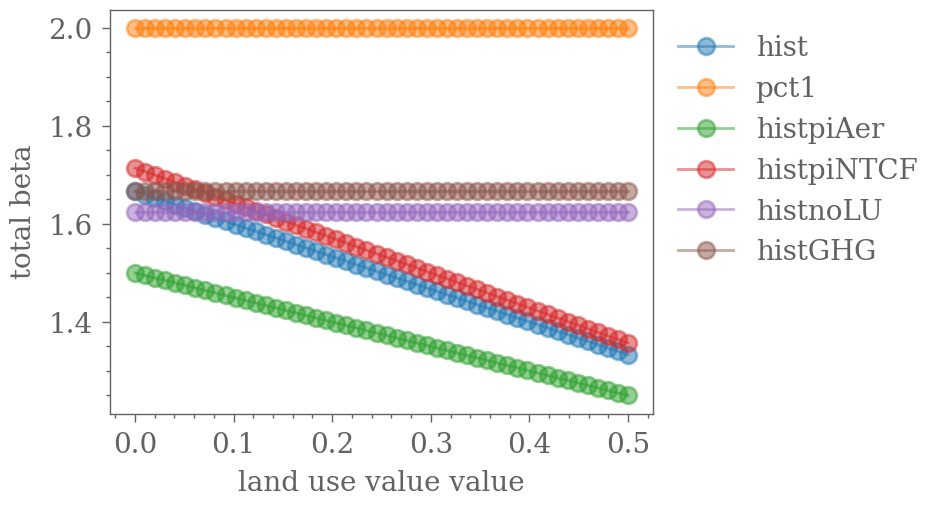

In [74]:


def simplified_beta( dTco2, dTWM, dTslcf, dTaer, dTLU, LU, beta=1, gamma=1,):
    LU_factor = LU/(dTco2 + dTWM+ dTslcf + dTaer+dTLU)
    if dTco2==0:
        return beta - LU_factor
    else:
        return beta + gamma*dTco2/(dTco2+dTWM + dTslcf+dTaer+dTLU) - LU_factor

gamma = 1
beta = 1
LU = .7
dTco2 = 1
dTWM = .5
dTslcf = .6
dTLU =-.1
dTaer = -.5
lu_array = np.linspace(0,.5)
_df = pd.DataFrame(index=lu_array, columns = ['hist','pct1','histpiAer','histpiNTCF','histnoLU','histGHG'])
for lu in lu_array:
    _df.loc[lu,'hist'] = simplified_beta(dTco2, dTWM, dTslcf, dTaer,dTLU, lu, beta, gamma)
    _df.loc[lu,'pct1']=  simplified_beta(dTco2, 0, 0, 0, 0,0, beta, gamma)
    _df.loc[lu,'histpiAer'] = simplified_beta(dTco2, dTWM, dTslcf, 0,dTLU, lu, beta, gamma)
    _df.loc[lu,'histpiNTCF'] = simplified_beta(dTco2, dTWM, 0, 0,dTLU, lu, beta, gamma)
    _df.loc[lu,'histnoLU'] = simplified_beta(dTco2, dTWM, dTslcf, dTaer, 0, 0, beta, gamma)
    _df.loc[lu,'histGHG'] = simplified_beta(dTco2, dTWM, 0, 0, 0,0, beta, gamma)

_df

_df.plot(marker='o', alpha=.5)
plt.legend(bbox_to_anchor=(1,1))
plt.xlabel('land use value value')
plt.ylabel('total beta')

In [75]:
simplified_beta(dTco2, dTWM, dTslcf, 0,dTLU, lu, beta, gamma)

1.25

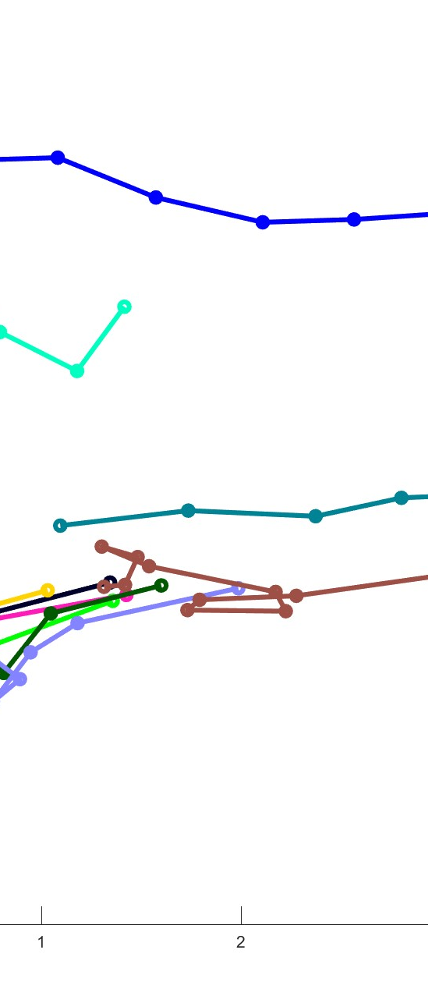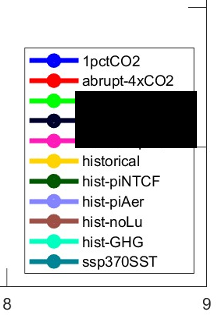

In [76]:
from matplotlib import colors

In [77]:
from matplotlib.colors import Normalize

In [78]:
class PiecewiseNorm(colors.Normalize):
    def __init__(self, levels, clip=False):
        # input levels
        self._levels = np.sort(levels)
        # corresponding normalized values between 0 and 1
        self._normed = np.linspace(0, 1, len(levels))
        Normalize.__init__(self, None, None, clip)

    def __call__(self, value, clip=None):
        # linearly interpolate to get the normalized value
        return np.ma.masked_array(np.interp(value, self._levels, self._normed))

    def inverse(self, value):
        return 1.0 - self.__call__(value)

T_C emiisop
FSDS_DRF emiisop


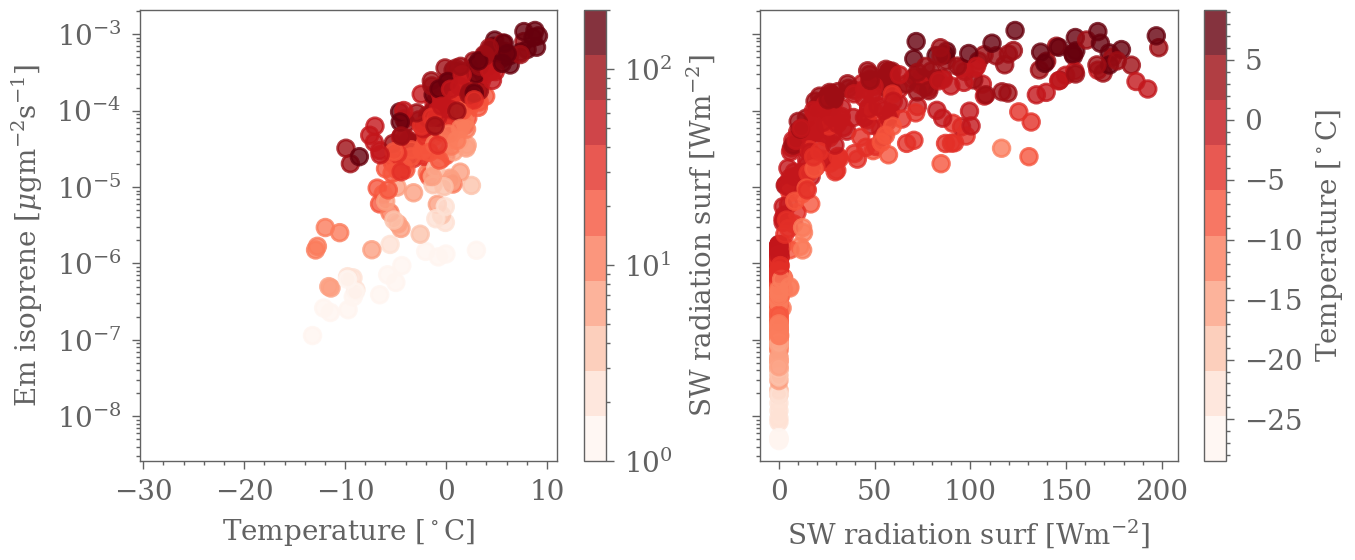

In [79]:
model_name = 'NorESM'
fig, axs = plt.subplots(1,2, figsize = [7,3], sharey=True)
axs = axs.flatten()

## Settings
alpha_scatt = 0.6

#xlab = r'T  [$^\circ$C]'
#ylab = r'Terpene emissions [$\mu$gm$^{-2}$s$^{-1}$]'#[$\mu g m^{-3}$]'
linewidth=2
#xlims =[5,30]
#ylims = [4e-3,4e-1]
#xlims = [22,37]


season='FMA'
v_x = 'T_C'
v_y = 'emiisop'
    

df_mo = dic_df_med[model_name]
mask_months = select_months(df_mo, season=season)
df_mo = df_mo[mask_months].copy()
ax = axs[0]
v_x = 'T_C'    
v_y = 'emiisop'
v_z = 'FSDS_DRF'

lab_x = 'Temperature [$^\circ$C]'
lab_y = 'Em isoprene [$\mu$gm$^{-2}$s$^{-1}$]'
lab_z = 'SW radiation surf [Wm$^{-2}$]'


ax = axs[0]
print(v_x,v_y)
s = ax.scatter(df_mo[v_x],df_mo[v_y], edgecolor=None, alpha=.8, 
               c=df_mo[v_z], 
               cmap=plt.cm.get_cmap('Reds', lut=10),
               norm=colors.LogNorm(1,200, )#,extend='both'
              
              )
plt.colorbar(s, label=lab_z, ax=ax, )
ax.set_xlabel(lab_x)
ax.set_ylabel(lab_y)

ax.set_yscale('log')






v_x = 'FSDS_DRF'
v_y = 'emiisop'
v_z = 'T_C'    

lab_x = 'SW radiation surf [Wm$^{-2}$]'
lab_y = 'Em isoprene [$\mu$gm$^{-2}$s$^{-1}$]'
lab_z = 'Temperature [$^\circ$C]'


ax = axs[1]
print(v_x,v_y)
s = ax.scatter(df_mo[v_x],df_mo[v_y], 
               edgecolor=None, 
               alpha=.8, 
               c=df_mo[v_z], 
               cmap=plt.cm.get_cmap('Reds', lut=10),
              )
plt.colorbar(s, label=lab_z, ax=ax)

ax.set_xlabel(lab_x)
#ax.set_ylabel(lab_y)

ax.set_yscale('log')
#ax.set_xscale('log')

plt.tight_layout()
plt.show()


In [80]:
df_mo['month'] =df_mo.index.month
df_mo['year'] =df_mo.index.year

T_C emiterp
FSDS_DRF emiterp


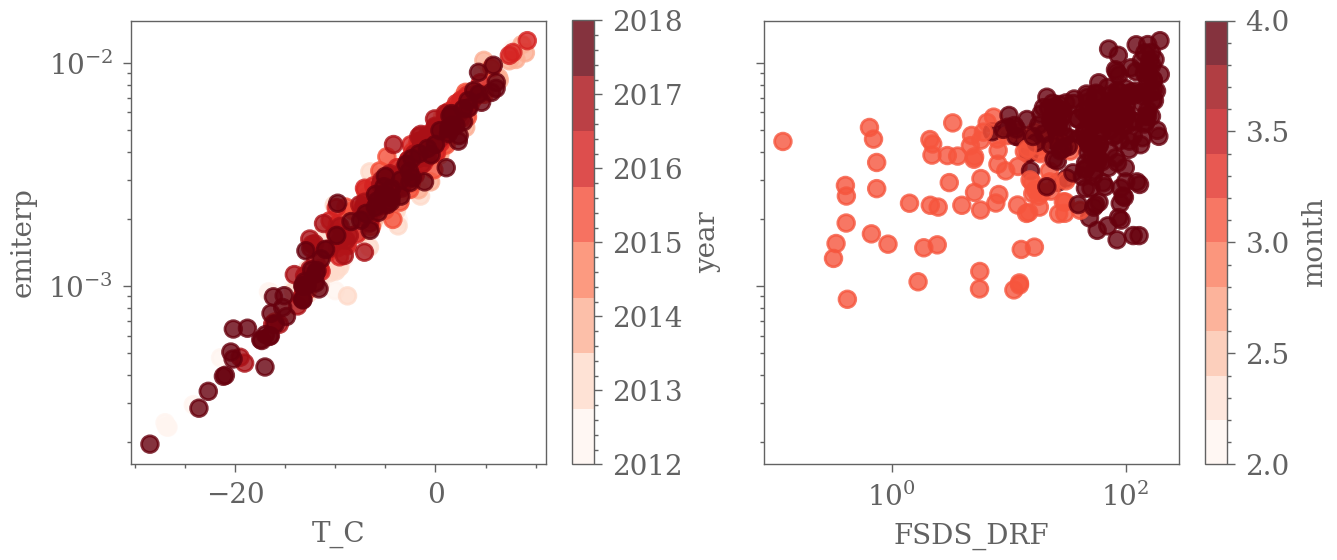

In [81]:
model_name = 'NorESM'
fig, axs = plt.subplots(1,2, figsize = [7,3], sharey=True)
axs = axs.flatten()

## Settings
alpha_scatt = 0.6

#xlab = r'T  [$^\circ$C]'
#ylab = r'Terpene emissions [$\mu$gm$^{-2}$s$^{-1}$]'#[$\mu g m^{-3}$]'
linewidth=2
#xlims =[5,30]
#ylims = [4e-3,4e-1]
#xlims = [22,37]


season='FMA'

    

df_mo = dic_df_med[model_name]
mask_months = select_months(df_mo, season=season)
df_mo = df_mo[mask_months].copy()
#df_mo = df_mo.loc['2015':None,:]
ax = axs[0]
v_x = 'T_C'    
v_y = 'emiterp'
v_z = 'year'

lab_x = v_x#'Temperature [$^\circ$C]'
lab_y = v_y#'Em terpene [$\mu$gm$^{-2}$s$^{-1}$]'
lab_z = v_z#'SW radiation surf [Wm$^{-2}$]'


ax = axs[0]
print(v_x,v_y)
s = ax.scatter(df_mo[v_x],df_mo[v_y], edgecolor=None, alpha=.8, 
               c=df_mo[v_z], 
               cmap=plt.cm.get_cmap('Reds', lut=8),
               #norm=colors.LogNorm(1,200, )#,extend='both'
              
              )
plt.colorbar(s, label=lab_z, ax=ax, )
ax.set_xlabel(lab_x)
ax.set_ylabel(lab_y)

ax.set_yscale('log')






v_x = 'FSDS_DRF'
v_y = 'emiterp'
v_z = 'month'#'T_C'    

lab_x = v_x#'SW radiation surf [Wm$^{-2}$]'
lab_y = v_y#'Em terpene [$\mu$gm$^{-2}$s$^{-1}$]'
lab_z = v_z#'month'#'Temperature [$^\circ$C]'


ax = axs[1]
print(v_x,v_y)
s = ax.scatter(df_mo[v_x],df_mo[v_y], 
               edgecolor=None, 
               alpha=.8, 
               c=df_mo[v_z], 
               cmap=plt.cm.get_cmap('Reds', lut=10),
              )
plt.colorbar(s, label=lab_z, ax=ax)

ax.set_xlabel(lab_x)
#ax.set_ylabel(lab_y)

ax.set_yscale('log')
ax.set_xscale('log')

plt.tight_layout()
plt.show()


T_C emiterp
FSDS_DRF emiterp


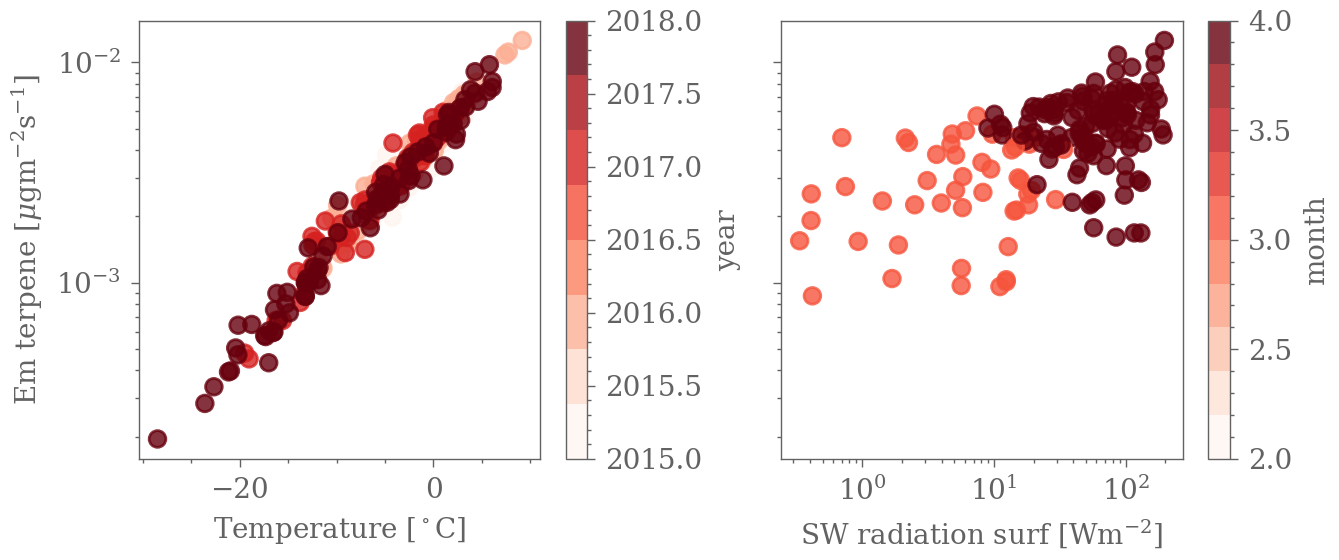

In [82]:
model_name = 'NorESM'
fig, axs = plt.subplots(1,2, figsize = [7,3], sharey=True)
axs = axs.flatten()

## Settings
alpha_scatt = 0.6

#xlab = r'T  [$^\circ$C]'
#ylab = r'Terpene emissions [$\mu$gm$^{-2}$s$^{-1}$]'#[$\mu g m^{-3}$]'
linewidth=2
#xlims =[5,30]
#ylims = [4e-3,4e-1]
#xlims = [22,37]


season='FMA'

    

df_mo = dic_df_med[model_name]
mask_months = select_months(df_mo, season=season)
df_mo = df_mo[mask_months].copy()
df_mo = df_mo.loc['2015':None,:]
ax = axs[0]
v_x = 'T_C'    
v_y = 'emiterp'
v_z = 'year'

lab_x = 'Temperature [$^\circ$C]'
lab_y = 'Em terpene [$\mu$gm$^{-2}$s$^{-1}$]'
lab_z = v_z#'SW radiation surf [Wm$^{-2}$]'


ax = axs[0]
print(v_x,v_y)
s = ax.scatter(df_mo[v_x],df_mo[v_y], edgecolor=None, alpha=.8, 
               c=df_mo[v_z], 
               cmap=plt.cm.get_cmap('Reds', lut=8),
               #norm=colors.LogNorm(1,200, )#,extend='both'
              
              )
plt.colorbar(s, label=lab_z, ax=ax, )
ax.set_xlabel(lab_x)
ax.set_ylabel(lab_y)

ax.set_yscale('log')






v_x = 'FSDS_DRF'
v_y = 'emiterp'
v_z = 'month'#'T_C'    

lab_x = 'SW radiation surf [Wm$^{-2}$]'
lab_y = 'Em terpene [$\mu$gm$^{-2}$s$^{-1}$]'
lab_z = 'month'#'Temperature [$^\circ$C]'


ax = axs[1]
print(v_x,v_y)
s = ax.scatter(df_mo[v_x],df_mo[v_y], 
               edgecolor=None, 
               alpha=.8, 
               c=df_mo[v_z], 
               cmap=plt.cm.get_cmap('Reds', lut=10),
              )
plt.colorbar(s, label=lab_z, ax=ax)

ax.set_xlabel(lab_x)
#ax.set_ylabel(lab_y)

ax.set_yscale('log')
ax.set_xscale('log')

plt.tight_layout()
plt.show()


T_C OA
FSDS_DRF OA


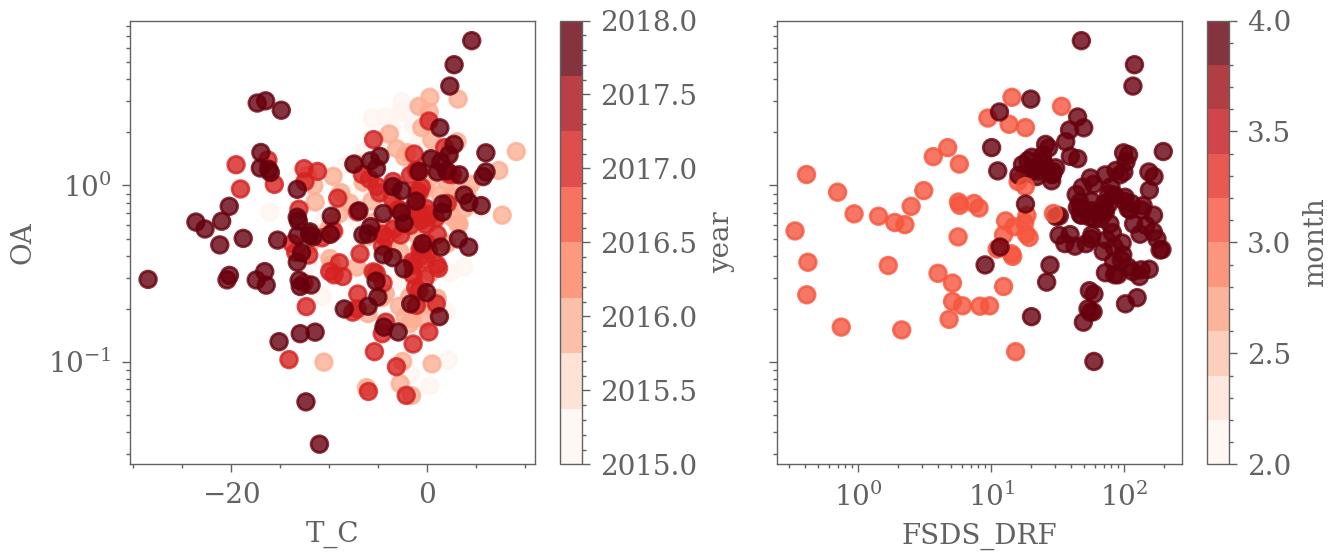

In [83]:
model_name = 'NorESM'
fig, axs = plt.subplots(1,2, figsize = [7,3], sharey=True)
axs = axs.flatten()

## Settings
alpha_scatt = 0.6

#xlab = r'T  [$^\circ$C]'
#ylab = r'Terpene emissions [$\mu$gm$^{-2}$s$^{-1}$]'#[$\mu g m^{-3}$]'
linewidth=2
#xlims =[5,30]
#ylims = [4e-3,4e-1]
#xlims = [22,37]


season='FMA'

    

df_mo = dic_df_med[model_name]
mask_months = select_months(df_mo, season=season)
df_mo = df_mo[mask_months].copy()
df_mo = df_mo.loc['2015':None,:]
ax = axs[0]
v_x = 'T_C'    
v_y = 'OA'
v_z = 'year'

lab_x = v_x#'Temperature [$^\circ$C]'
lab_y = v_y#'Em terpene [$\mu$gm$^{-2}$s$^{-1}$]'
lab_z = v_z#'SW radiation surf [Wm$^{-2}$]'


ax = axs[0]
print(v_x,v_y)
s = ax.scatter(df_mo[v_x],df_mo[v_y], edgecolor=None, alpha=.8, 
               c=df_mo[v_z], 
               cmap=plt.cm.get_cmap('Reds', lut=8),
               #norm=colors.LogNorm(1,200, )#,extend='both'
              
              )
plt.colorbar(s, label=lab_z, ax=ax, )
ax.set_xlabel(lab_x)
ax.set_ylabel(lab_y)

ax.set_yscale('log')






v_x = 'FSDS_DRF'
v_y = 'OA'
v_z = 'month'#'T_C'    

lab_x = v_x#'SW radiation surf [Wm$^{-2}$]'
lab_y = v_y #'Em terpene [$\mu$gm$^{-2}$s$^{-1}$]'
lab_z = v_z#'month'#'Temperature [$^\circ$C]'


ax = axs[1]
print(v_x,v_y)
s = ax.scatter(df_mo[v_x],df_mo[v_y], 
               edgecolor=None, 
               alpha=.8, 
               c=df_mo[v_z], 
               cmap=plt.cm.get_cmap('Reds', lut=10),
              )
plt.colorbar(s, label=lab_z, ax=ax)

ax.set_xlabel(lab_x)
#ax.set_ylabel(lab_y)

ax.set_yscale('log')
ax.set_xscale('log')

plt.tight_layout()
plt.show()


emiterp OA
emiterp OA


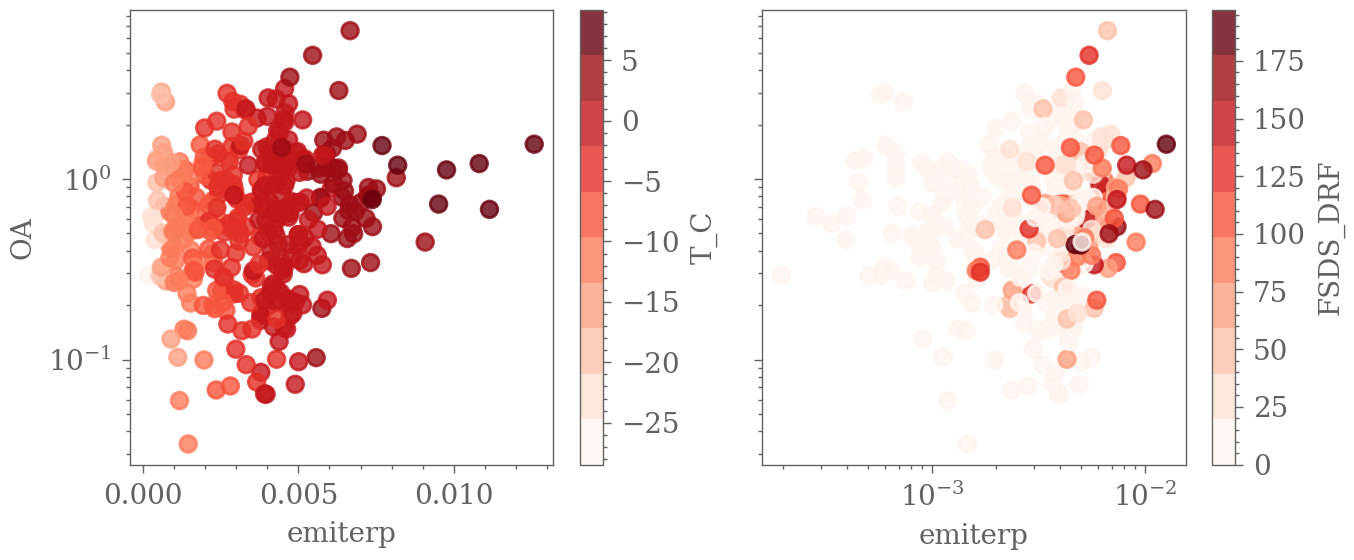

In [84]:
model_name = 'NorESM'
fig, axs = plt.subplots(1,2, figsize = [7,3], sharey=True)
axs = axs.flatten()

## Settings
alpha_scatt = 0.6

#xlab = r'T  [$^\circ$C]'
#ylab = r'Terpene emissions [$\mu$gm$^{-2}$s$^{-1}$]'#[$\mu g m^{-3}$]'
linewidth=2
#xlims =[5,30]
#ylims = [4e-3,4e-1]
#xlims = [22,37]


season='FMA'

    

df_mo = dic_df_med[model_name]
mask_months = select_months(df_mo, season=season)
df_mo = df_mo[mask_months].copy()
df_mo = df_mo.loc['2015':None,:]
ax = axs[0]
v_x = 'emiterp'    
v_y = 'OA'
v_z = 'T_C'

lab_x = v_x
lab_y = v_y
lab_z = v_z


ax = axs[0]
print(v_x,v_y)
s = ax.scatter(df_mo[v_x],df_mo[v_y], edgecolor=None, alpha=.8, 
               c=df_mo[v_z], 
               cmap=plt.cm.get_cmap('Reds', lut=10),
               #norm=colors.LogNorm(1,200, )#,extend='both'
              
              )
plt.colorbar(s, label=lab_z, ax=ax, )
ax.set_xlabel(lab_x)
ax.set_ylabel(lab_y)

ax.set_yscale('log')


v_z = 'FSDS_DRF'
lab_x = v_x
lab_y = v_y
lab_z = v_z


ax = axs[1]
print(v_x,v_y)
s = ax.scatter(df_mo[v_x],df_mo[v_y], 
               edgecolor=None, 
               alpha=.8, 
               c=df_mo[v_z], 
               cmap=plt.cm.get_cmap('Reds', lut=10),
              )
plt.colorbar(s, label=lab_z, ax=ax)

ax.set_xlabel(lab_x)
#ax.set_ylabel(lab_y)

ax.set_yscale('log')
ax.set_xscale('log')

plt.tight_layout()
plt.show()


emiterp OA
emiterp OA


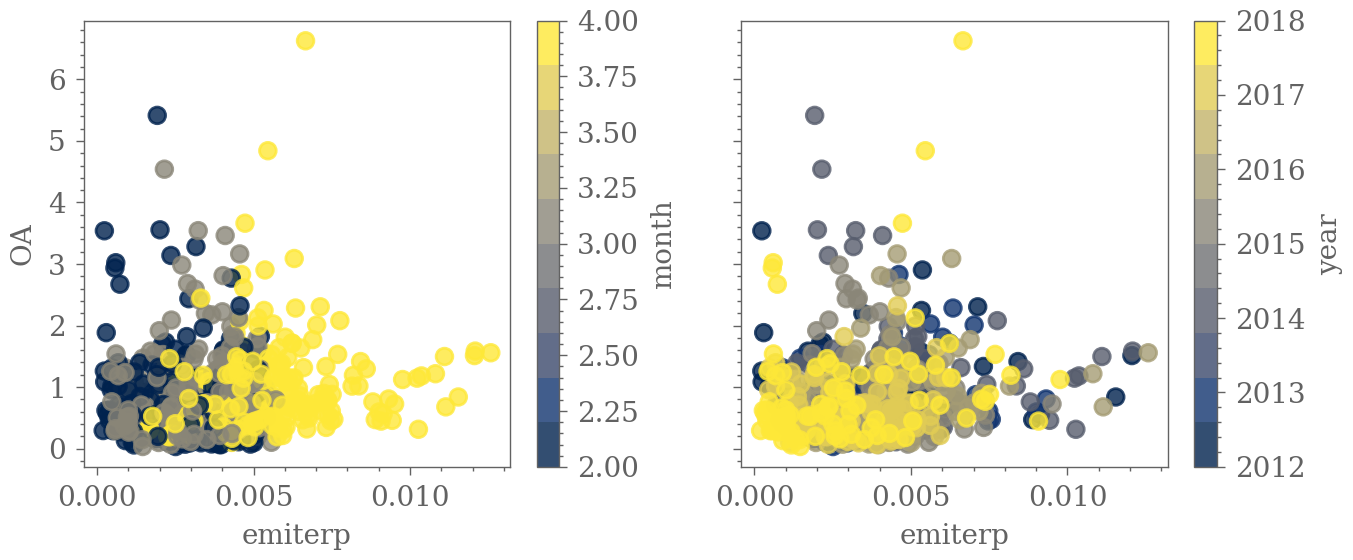

In [85]:
model_name = 'NorESM'
fig, axs = plt.subplots(1,2, figsize = [7,3], sharey=True)
axs = axs.flatten()

## Settings
alpha_scatt = 0.6

#xlab = r'T  [$^\circ$C]'
#ylab = r'Terpene emissions [$\mu$gm$^{-2}$s$^{-1}$]'#[$\mu g m^{-3}$]'
linewidth=2
#xlims =[5,30]
#ylims = [4e-3,4e-1]
#xlims = [22,37]


season='FMA'

    

df_mo = dic_df_med[model_name]
mask_months = select_months(df_mo, season=season)
df_mo = df_mo[mask_months].copy()
ax = axs[0]
v_x = 'emiterp'    
v_y = 'OA'
v_z = 'month'

lab_x = v_x
lab_y = v_y
lab_z = v_z


ax = axs[0]
print(v_x,v_y)
s = ax.scatter(df_mo[v_x],df_mo[v_y], edgecolor=None, alpha=.8, 
               c=df_mo[v_z], 
               cmap=plt.cm.get_cmap('cividis', lut=10),
               #norm=colors.LogNorm(1,200, )#,extend='both'
              
              )
plt.colorbar(s, label=lab_z, ax=ax, )
ax.set_xlabel(lab_x)
ax.set_ylabel(lab_y)

ax.set_yscale('log')


v_z = 'year'
lab_x = v_x
lab_y = v_y
lab_z = v_z


ax = axs[1]
print(v_x,v_y)
s = ax.scatter(df_mo[v_x],df_mo[v_y], 
               edgecolor=None, 
               alpha=.8, 
               c=df_mo[v_z], 
               cmap=plt.cm.get_cmap('cividis', lut=10),
              )
plt.colorbar(s, label=lab_z, ax=ax)

ax.set_xlabel(lab_x)
#ax.set_ylabel(lab_y)

ax.set_yscale('linear')
ax.set_xscale('linear')

plt.tight_layout()
plt.show()


emiisop OA
emiisop OA


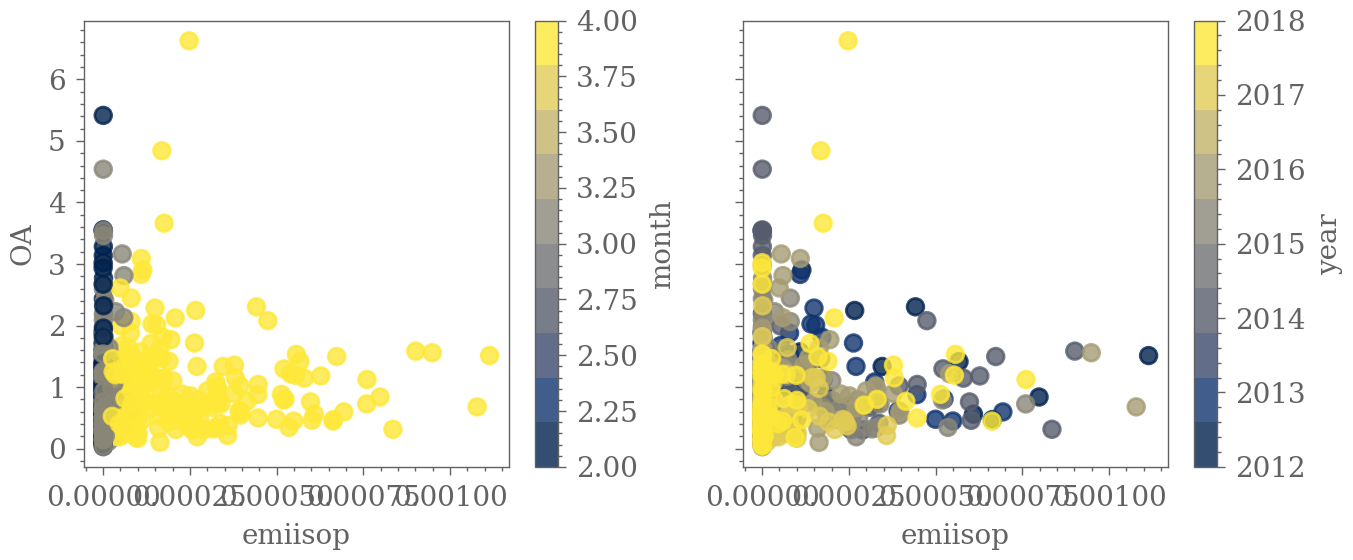

In [86]:
model_name = 'NorESM'
fig, axs = plt.subplots(1,2, figsize = [7,3], sharey=True)
axs = axs.flatten()

## Settings
alpha_scatt = 0.6

#xlab = r'T  [$^\circ$C]'
#ylab = r'Terpene emissions [$\mu$gm$^{-2}$s$^{-1}$]'#[$\mu g m^{-3}$]'
linewidth=2
#xlims =[5,30]
#ylims = [4e-3,4e-1]
#xlims = [22,37]


season='FMA'

    

df_mo = dic_df_med[model_name]
mask_months = select_months(df_mo, season=season)
df_mo = df_mo[mask_months].copy()
ax = axs[0]
v_x = 'emiisop'    
v_y = 'OA'
v_z = 'month'

lab_x = v_x
lab_y = v_y
lab_z = v_z


ax = axs[0]
print(v_x,v_y)
s = ax.scatter(df_mo[v_x],df_mo[v_y], edgecolor=None, alpha=.8, 
               c=df_mo[v_z], 
               cmap=plt.cm.get_cmap('cividis', lut=10),
               #norm=colors.LogNorm(1,200, )#,extend='both'
              
              )
plt.colorbar(s, label=lab_z, ax=ax, )
ax.set_xlabel(lab_x)
ax.set_ylabel(lab_y)

ax.set_yscale('log')


v_z = 'year'
lab_x = v_x
lab_y = v_y
lab_z = v_z


ax = axs[1]
print(v_x,v_y)
s = ax.scatter(df_mo[v_x],df_mo[v_y], 
               edgecolor=None, 
               alpha=.8, 
               c=df_mo[v_z], 
               cmap=plt.cm.get_cmap('cividis', lut=10),
              )
plt.colorbar(s, label=lab_z, ax=ax)

ax.set_xlabel(lab_x)
#ax.set_ylabel(lab_y)

ax.set_yscale('linear')
ax.set_xscale('linear')

plt.tight_layout()
plt.show()


emiisop OA
emiisop OA


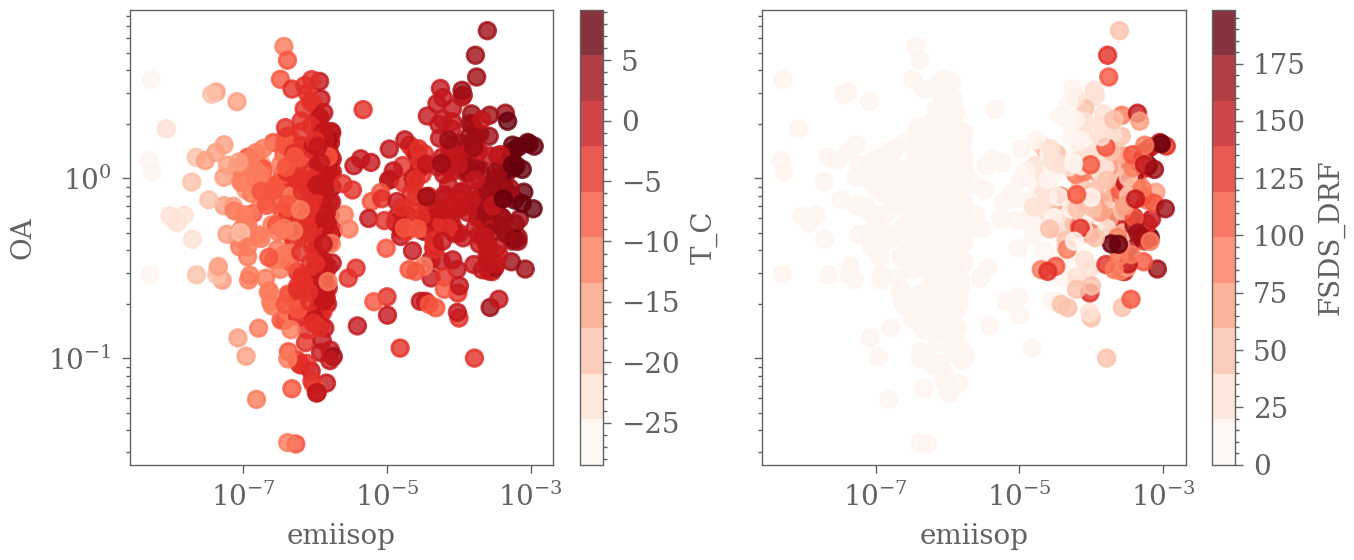

In [87]:
model_name = 'NorESM'
fig, axs = plt.subplots(1,2, figsize = [7,3], sharey=True)
axs = axs.flatten()

## Settings
alpha_scatt = 0.6

#xlab = r'T  [$^\circ$C]'
#ylab = r'Terpene emissions [$\mu$gm$^{-2}$s$^{-1}$]'#[$\mu g m^{-3}$]'
linewidth=2
#xlims =[5,30]
#ylims = [4e-3,4e-1]
#xlims = [22,37]


season='FMA'

    

df_mo = dic_df_med[model_name]
mask_months = select_months(df_mo, season=season)
df_mo = df_mo[mask_months].copy()
ax = axs[0]
v_x = 'emiisop'    
v_y = 'OA'
v_z = 'T_C'

lab_x = v_x
lab_y = v_y
lab_z = v_z


ax = axs[0]
print(v_x,v_y)
s = ax.scatter(df_mo[v_x],df_mo[v_y], edgecolor=None, alpha=.8, 
               c=df_mo[v_z], 
               cmap=plt.cm.get_cmap('Reds', lut=10),
               #norm=colors.LogNorm(1,200, )#,extend='both'
              
              )
plt.colorbar(s, label=lab_z, ax=ax, )
ax.set_xlabel(lab_x)
ax.set_ylabel(lab_y)

ax.set_yscale('log')
ax.set_yscale('log')
ax.set_xscale('log')

v_z = 'FSDS_DRF'
lab_x = v_x
lab_y = v_y
lab_z = v_z


ax = axs[1]
print(v_x,v_y)
s = ax.scatter(df_mo[v_x],df_mo[v_y], 
               edgecolor=None, 
               alpha=.8, 
               c=df_mo[v_z], 
               cmap=plt.cm.get_cmap('Reds', lut=10),
              )
plt.colorbar(s, label=lab_z, ax=ax)

ax.set_xlabel(lab_x)
#ax.set_ylabel(lab_y)

ax.set_yscale('log')
ax.set_xscale('log')

plt.tight_layout()
plt.show()


emiisop OA
emiisop OA


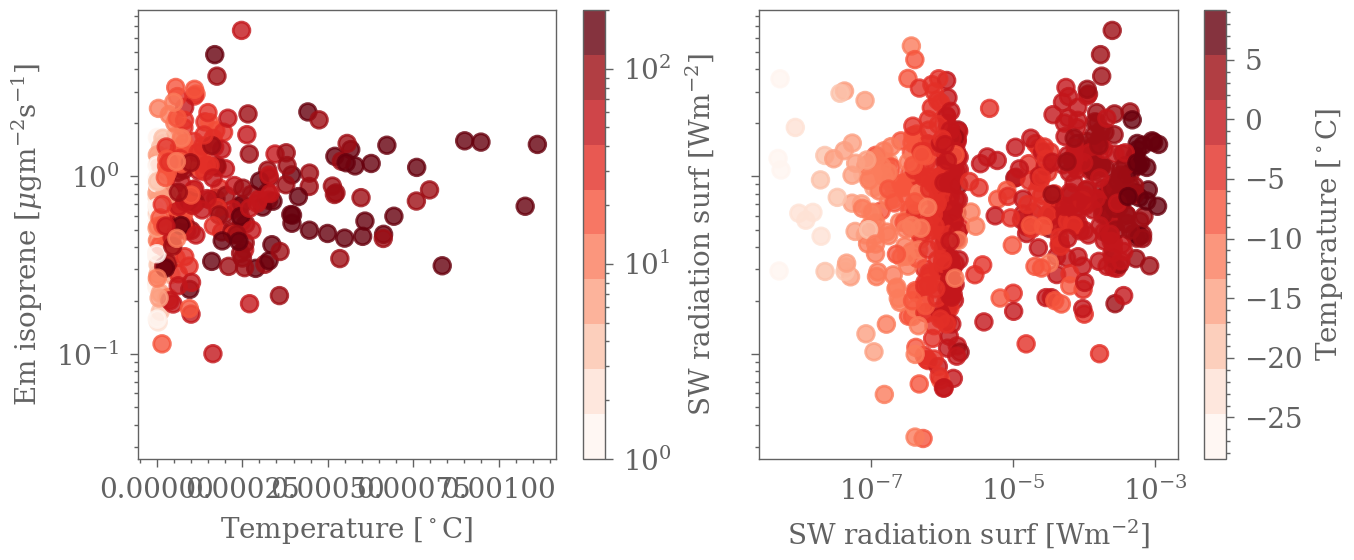

In [88]:
model_name = 'NorESM'
fig, axs = plt.subplots(1,2, figsize = [7,3], sharey=True)
axs = axs.flatten()

## Settings
alpha_scatt = 0.6

#xlab = r'T  [$^\circ$C]'
#ylab = r'Terpene emissions [$\mu$gm$^{-2}$s$^{-1}$]'#[$\mu g m^{-3}$]'
linewidth=2
#xlims =[5,30]
#ylims = [4e-3,4e-1]
#xlims = [22,37]


season='FMA'

    

df_mo = dic_df_med[model_name]
mask_months = select_months(df_mo, season=season)
df_mo = df_mo[mask_months].copy()
ax = axs[0]
v_x = 'emiisop'    
v_y = 'OA'
v_z = 'FSDS_DRF'

lab_x = 'Temperature [$^\circ$C]'
lab_y = 'Em isoprene [$\mu$gm$^{-2}$s$^{-1}$]'
lab_z = 'SW radiation surf [Wm$^{-2}$]'


ax = axs[0]
print(v_x,v_y)
s = ax.scatter(df_mo[v_x],df_mo[v_y], edgecolor=None, alpha=.8, 
               c=df_mo[v_z], 
               cmap=plt.cm.get_cmap('Reds', lut=10),
               norm=colors.LogNorm(1,200, )#,extend='both'
              
              )
plt.colorbar(s, label=lab_z, ax=ax, )
ax.set_xlabel(lab_x)
ax.set_ylabel(lab_y)

ax.set_yscale('log')




v_x = 'emiisop'    
v_y = 'OA'
v_z = 'T_C'    

lab_x = 'SW radiation surf [Wm$^{-2}$]'
lab_y = 'Em isoprene [$\mu$gm$^{-2}$s$^{-1}$]'
lab_z = 'Temperature [$^\circ$C]'


ax = axs[1]
print(v_x,v_y)
s = ax.scatter(df_mo[v_x],df_mo[v_y], 
               edgecolor=None, 
               alpha=.8, 
               c=df_mo[v_z], 
               cmap=plt.cm.get_cmap('Reds', lut=10),
              )
plt.colorbar(s, label=lab_z, ax=ax)

ax.set_xlabel(lab_x)
#ax.set_ylabel(lab_y)

ax.set_yscale('log')
ax.set_xscale('log')

plt.tight_layout()
plt.show()


T_C emiisop
T_C emiisop
FSDS_DRF emiterp


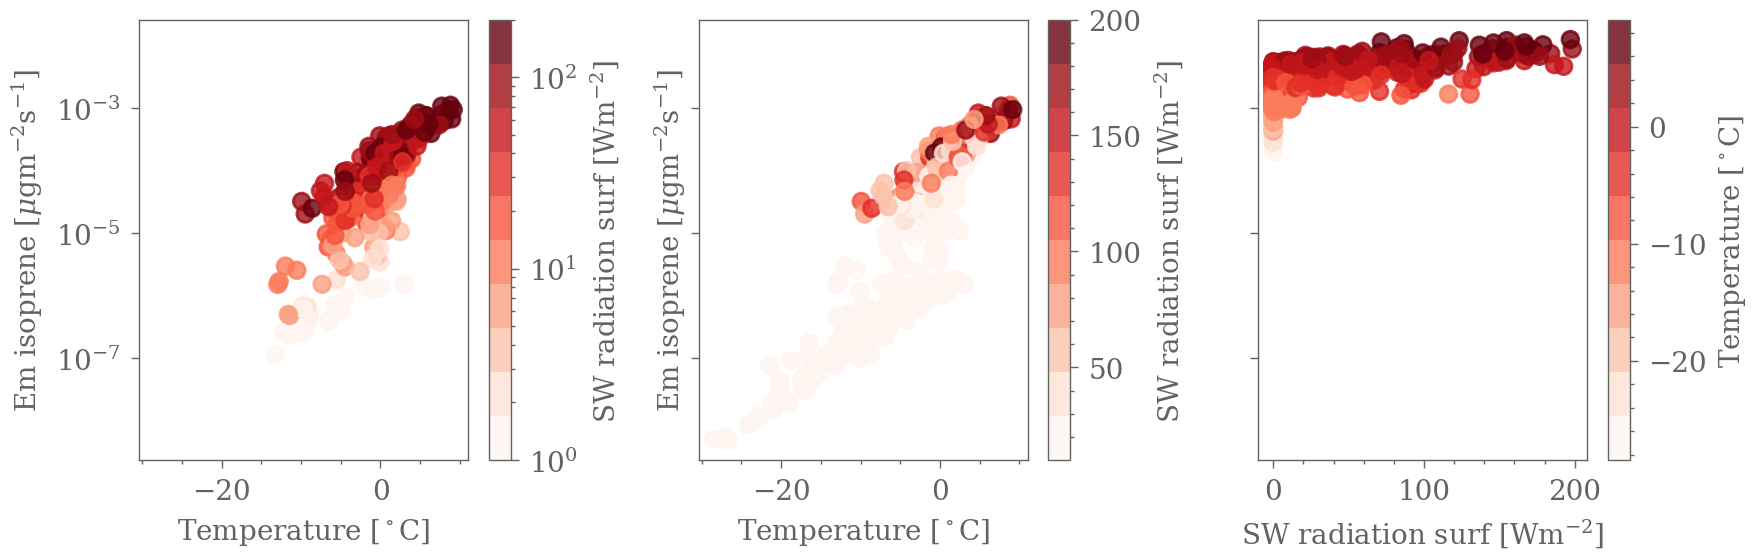

In [89]:
model_name = 'NorESM'
fig, axs = plt.subplots(1,3, figsize = [9,3], sharey=True)
axs = axs.flatten()

## Settings
alpha_scatt = 0.6

#xlab = r'T  [$^\circ$C]'
#ylab = r'Terpene emissions [$\mu$gm$^{-2}$s$^{-1}$]'#[$\mu g m^{-3}$]'
linewidth=2
#xlims =[5,30]
#ylims = [4e-3,4e-1]
#xlims = [22,37]


season='FMA'
v_x = 'T_C'
v_y = 'emiterp'
    

df_mo = dic_df_med[model_name]
mask_months = select_months(df_mo, season=season)
df_mo = df_mo[mask_months].copy()
ax = axs[0]
v_x = 'T_C'    
v_y = 'emiisop'
v_z = 'FSDS_DRF'

lab_x = 'Temperature [$^\circ$C]'
lab_y = 'Em isoprene [$\mu$gm$^{-2}$s$^{-1}$]'
lab_z = 'SW radiation surf [Wm$^{-2}$]'


ax = axs[0]
print(v_x,v_y)
s = ax.scatter(df_mo[v_x],df_mo[v_y], edgecolor=None, alpha=.8, 
               c=df_mo[v_z], 
               cmap=plt.cm.get_cmap('Reds', lut=10),
               norm=colors.LogNorm(1,200, )#,extend='both'
              
              )
plt.colorbar(s, label=lab_z, ax=ax)
ax.set_xlabel(lab_x)
ax.set_ylabel(lab_y)

ax.set_yscale('log')


ax = axs[1]
print(v_x,v_y)
s = ax.scatter(df_mo[v_x],df_mo[v_y], edgecolor=None, alpha=.8, 
               c=df_mo[v_z], 
               cmap=plt.cm.get_cmap('Reds', lut=10),
               norm=colors.Normalize(10,200, )#,extend='both'
              
              )
plt.colorbar(s, label=lab_z, ax=ax)
ax.set_xlabel(lab_x)
ax.set_ylabel(lab_y)

ax.set_yscale('log')



v_x = 'FSDS_DRF'
v_y = 'emiterp'
v_z = 'T_C'    

lab_x = 'SW radiation surf [Wm$^{-2}$]'
lab_y = 'Em isoprene [$\mu$gm$^{-2}$s$^{-1}$]'
lab_z = 'Temperature [$^\circ$C]'


ax = axs[2]
print(v_x,v_y)
s = ax.scatter(df_mo[v_x],df_mo[v_y], 
               edgecolor=None, 
               alpha=.8, 
               c=df_mo[v_z], 
               cmap=plt.cm.get_cmap('Reds', lut=10),
              )
plt.colorbar(s, label=lab_z, ax=ax)

ax.set_xlabel(lab_x)
#ax.set_ylabel(lab_y)

ax.set_yscale('log')
#ax.set_xscale('log')

plt.tight_layout()
plt.show()


In [90]:
dic_ds[ca]

NameError: name 'dic_ds' is not defined

In [ ]:
import matplotlib.colors as colors

In [ ]:
colors.No

In [ ]:
plt.cm.get_cmap('Reds', lut=10)

In [ ]:
sns.scatterplot(v_x,v_y,data = df_mo, ax= ax, edgecolor=None, alpha=.3)
